In [1]:
#0 Docker, 1 CloudVeneto
FIGHTER = 1

# la porta dove vedere i jobs 
SparkUI = 4042

user = 'user_a'
core = 8
Npartition = 8

In [2]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 
           'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107','S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 
           'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126' , 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 
           'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 
           'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 
           'S2', 'S201', 'S202', 'S203', 'S204', 'S205','S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43',
           'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 
           'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3','SA4', 'SA5', 
           'SA6','SA7', 'SA8', 'SA9', 'SW']

In [3]:
# Standard libraries
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt

# PySpark core
from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F



# PySpark functions
from pyspark.sql.functions import (
    coalesce,
    col, lit, expr, when, count, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, row_number, desc, asc,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id
)

In [4]:
if FIGHTER==0:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1000m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

elif FIGHTER==1:

        os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
        
        spark = SparkSession.builder \
            .appName("ProjectCloudVeneto") \
            .master("spark://10.67.22.135:7077") \
            .config("spark.scheduler.mode", "FAIR") \
            .config("spark.scheduler.pool", user) \
            .config("spark.scheduler.allocation.file", "file:///usr/local/spark/conf/fairscheduler.xml") \
            .config("spark.cores.max", core) \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
            .config("spark.dynamicAllocation.enabled", "false") \
            .config("spark.shuffle.service.enabled", "false") \
            .config("spark.ui.port", SparkUI) \
            .getOrCreate()
    
else : print("Better choose an available fighter, you little bastard.")

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/13 08:27:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
if FIGHTER==0:
    df = spark.read.option("header", True).option("inferSchema", True).csv("/ProvePreliminari/SW-106.csv")

elif FIGHTER==1:
    df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv")

else:
    print("Better choose an available fighter, you little bastard")

df = df.repartition(Npartition)

In [6]:
# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

hardware = "SW-106"
df_hw = df  .filter(col("hwid") == hardware)\
            .groupBy("when")\
            .pivot("metric")\
            .agg(first("value"))\
            .withColumn("time", from_unixtime(col("when")))\
            .orderBy("when")

df_hw = df_hw.persist()
df_hw.count()

25/08/13 08:28:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

398039

In [7]:
def FillGaps(
    df: DataFrame,
    sensors: list = None,
    interval: int = 60,
    modality: str = 'auto',
) -> DataFrame:
    """
    Aggregates sensor data into fixed-size time windows and fills missing values using Spark.

    Args:
        df: Spark DataFrame with a 'when' column (UNIX timestamp in seconds).
        sensors: List of sensor column names. If None, inferred from all columns except 'when' and 'time'.
        interval: Window size in seconds.
        modality: Aggregation method: 'mean', 'min', 'max', 'mode', or 'auto'.
        fill_null: If True, fills missing values using forward and backward fill in Spark.

    Returns:
        Aggregated and optionally gap-filled DataFrame, with a `when` column at the center of the window
        and a `window_id` column that uniquely identifies each time window.
    """

    # 1. Infer sensor columns if not provided
    if sensors is None:
        sensors = [c for c in df.columns if c not in ("when", "time")]

    # 2. Add timestamp column
    df_ts = df.withColumn("timestamp", from_unixtime(col("when")).cast("timestamp"))

    # 3. Create time window
    df_windowed = df_ts.withColumn("time_window", window("timestamp", f"{interval} seconds"))

    # 4. Aggregate using selected modality
    if modality == "mode":
        # Special case: MODE needs groupBy and count per window + sensor
        aggs = []
        for s in sensors:
            mode_df = (
                df_windowed.groupBy("time_window", s)
                .agg(count("*").alias("cnt"))
                .withColumn("rank", row_number().over(
                    Window.partitionBy("time_window").orderBy(desc("cnt"))
                ))
                .filter(col("rank") == 1)
                .select("time_window", col(s).alias(s))
            )
            if not aggs:
                result_df = mode_df
            else:
                result_df = result_df.join(mode_df, on="time_window", how="outer")
    else:
        aggs = []
        for s in sensors:
            if modality == "mean":
                agg_func = spark_avg(col(s)).alias(s)
            elif modality == "min":
                agg_func = spark_min(col(s)).alias(s)
            elif modality == "max":
                agg_func = spark_max(col(s)).alias(s)
            elif modality == "auto":
                stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
                is_binary = stats["min"] is not None and stats["max"] is not None and 0 <= stats["min"] and stats["max"] <= 1
                if s in ["A5", "A9"] or is_binary:
                    agg_func = spark_max(col(s)).alias(s)
                else:
                    agg_func = spark_avg(col(s)).alias(s)
            else:
                raise ValueError(f"Unsupported modality: {modality}")
            aggs.append(agg_func)

        result_df = (
            df_windowed
            .groupBy("time_window")
            .agg(*aggs)
        )

    # 5. Add window_start, window_end, and 'when' as center of window
    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )


    return result_df.select(["when", "window_start", "window_end"] + sensors)


In [8]:
%%time

frequency = 60 #seconds

# Fill sensor gaps
df_grid = FillGaps(df_hw, interval=frequency, modality="auto")
df_grid = df_grid.persist()

# Trigger persist
df_grid.count()
#df_hw.unpersist()

[Stage 1531:==================================================> (195 + 4) / 200]

CPU times: user 240 ms, sys: 91 ms, total: 331 ms
Wall time: 1min 5s


105885

In [29]:
def BuildBlocks(df, max_interval):
    #Block Partitioning
    w_global = Window.partitionBy(F.lit(1)).orderBy("when")
    df = (df
          .withColumn("Prev_TimeStamp", F.lag("when").over(w_global))
          .withColumn("Next_TimeStamp", F.lead("when").over(w_global))
          .withColumn("PrevDiff_s", F.col("when") - F.col("Prev_TimeStamp"))
          .withColumn("NextDiff_s", F.col("Next_TimeStamp") - F.col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn(
        "CheckNewBlock",
        F.when(F.col("PrevDiff_s") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", F.sum("CheckNewBlock").over(w_global))

    #Copy these rows if there are any gaps (timediff > 60 but less than max_interval)
    skip_cols = {
        "when", "Prev_TimeStamp", "Next_TimeStamp",
        "PrevDiff_s", "NextDiff_s", "CheckNewBlock", "BlockID",
        "window_start", "window_end"}
    other_cols = [c for c in df.columns if c not in skip_cols]

    # Next values within EACH block
    w_block = Window.partitionBy("BlockID").orderBy("when")
    for c in other_cols:
        df = df.withColumn(f"Next_{c}", F.lead(c).over(w_block))

    #Fill counts only for intra-block gaps: 60 < gap < max_interval
    df = df.withColumn(
        "NumFill",
        F.when(
            (F.col("NextDiff_s") > 60) & (F.col("NextDiff_s") < max_interval),
            (F.floor(F.col("NextDiff_s")/60) - 1).cast("int")).otherwise(0))

    #Timestamps to insert between current and next row (every 60s)
    df = df.withColumn("FillTimestamps",
            F.when(
            F.col("NumFill") > 0,
            F.expr("sequence(when + 60, Next_TimeStamp - 60, 60)")).otherwise(F.array()))

    #Artificial rows copy NEXT row's non-time columns
    fill_rows = (df
        .filter(F.col("NumFill") > 0)
        .select("BlockID",
            F.explode("FillTimestamps").alias("when"),
            *[F.col(f"Next_{c}").alias(c) for c in other_cols],
            F.lit(True).alias("is_artificial")))

    #Original rows
    original_rows = df.select("BlockID", "when", *other_cols, F.lit(False).alias("is_artificial"))

    #Union, order, recompute windows from 'when'
    final = (original_rows.unionByName(fill_rows)
             .orderBy("BlockID", "when"))

    # Recompute window_id and window bounds
    w_block_final = Window.partitionBy("BlockID").orderBy("when")
    final = (final
             .withColumn("window_id", F.row_number().over(w_block_final) - 1)
             .withColumn("window_start", F.from_unixtime(F.col("when") - 30))
             .withColumn("window_end",   F.from_unixtime(F.col("when") + 30)))

    #Recompute TimeDiff_s after filling
    final = (final
             .withColumn("PrevWhenInBlock", F.lag("when").over(w_block_final))
             .withColumn("TimeDiff_s",
                 F.when(F.col("PrevWhenInBlock").isNull(), F.lit(None).cast("int"))
                  .otherwise(F.col("when") - F.col("PrevWhenInBlock"))).drop("PrevWhenInBlock"))

    return final

In [30]:
df_final_test = BuildBlocks(df_grid, max_interval = 240).persist()
#df_grid.unpersist()


In [31]:
df_final_test.select("window_id", "when", 'window_start', 'window_end', 'BlockID').orderBy('BlockID').show(2000)

[Stage 1984:================================================>   (187 + 2) / 200]

+---------+----------+-------------------+-------------------+-------+
|window_id|      when|       window_start|         window_end|BlockID|
+---------+----------+-------------------+-------------------+-------+
|        0|1601510430|2020-10-01 00:00:00|2020-10-01 00:01:00|      0|
|        1|1601510490|2020-10-01 00:01:00|2020-10-01 00:02:00|      0|
|        2|1601510550|2020-10-01 00:02:00|2020-10-01 00:03:00|      0|
|        3|1601510610|2020-10-01 00:03:00|2020-10-01 00:04:00|      0|
|        4|1601510670|2020-10-01 00:04:00|2020-10-01 00:05:00|      0|
|        5|1601510730|2020-10-01 00:05:00|2020-10-01 00:06:00|      0|
|        6|1601510790|2020-10-01 00:06:00|2020-10-01 00:07:00|      0|
|        7|1601510850|2020-10-01 00:07:00|2020-10-01 00:08:00|      0|
|        8|1601510910|2020-10-01 00:08:00|2020-10-01 00:09:00|      0|
|        9|1601510970|2020-10-01 00:09:00|2020-10-01 00:10:00|      0|
|       10|1601511030|2020-10-01 00:10:00|2020-10-01 00:11:00|      0|
|     

# Test correlation

In [11]:
from pyspark.sql.functions import approx_count_distinct
'''Queste due funzioni forse si potrebbero unire, la prima impiega 0.5s la seconda circa 6s'''

#Given the dataframe, returns a dataframe with (approx.) the number of unique values assumed by each sensor in grouped by BlockID
#To be called once after Anomaly detection
def ChangingMetrics(df):

    ExcludedCol = {"window_id", "when", "window_start", "window_end", "ComError", 
                     "Prev_TimeStamp", "TimeDiff_s", "CheckNewBlock", "BlockID"}
    
    ColToCount = [c for c in df.columns if c not in ExcludedCol]
    
    agg_exprs = [approx_count_distinct(c).alias(c) for c in ColToCount]
    
    # Aggregate distinct counts per BlockID
    counts_df = df.groupBy("BlockID").agg(*agg_exprs).orderBy('BlockID')

    return counts_df

#Given the df of counts and the BlockID, returns the metric that changes at least 10 times
#To be called for every anomalous block
def SpecificMetric(counts_df, BlockID, minCounts = 10):

    row = counts_df.filter(col("BlockID") == BlockID).collect()
            
    # Extract the row as dictionary and filter keys with count > minCounts
    row_dict = row[0].asDict()
    filtered_sensors = [k for k, v in row_dict.items() if k != "BlockID" and v > minCounts]
    return filtered_sensors


In [12]:
%%time
MetricDF = ChangingMetrics(df_final)

CPU times: user 23.2 ms, sys: 19.3 ms, total: 42.5 ms
Wall time: 834 ms


In [13]:
%%time

Metric118 = SpecificMetric(MetricDF, BlockID=118)

25/08/09 07:16:40 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
25/08/09 07:16:45 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
[Stage 1616:===================================================>(199 + 1) / 200]

CPU times: user 11.5 ms, sys: 10.1 ms, total: 21.6 ms
Wall time: 10.4 s


In [14]:
#Return a list of the anomalous blockID
def AnomalousBlock(AnomalousDF):

    #AnomalousDF is the output of the AnomalyDetection algorithm

    result = (AnomalousDF
            .groupBy("BlockID")
            .agg(F.max("HasAnomaly").alias("HasAnomalyFlag"))
            .filter(F.col("HasAnomalyFlag") == 1)
            .select("BlockID")
            .distinct())

    #Retrieve results as a list
    return [row["BlockID"] for row in result.collect()]
    

In [15]:
'''
QUINDI LA PIPELINE:

1. PREPROCESSING DEL DATASET
2. ALGORITMO DI ANOMALY DETECTION CON LA COLONNA HAS_ANOMALY SE I 4 SENSORI SONO ANOMALY. 
3. RICONOSCIMENTO BLOCCHI ANOMALI
4. APPLICAZIONE CHANGING METRICS

5. LOOP SU TUTTI I BLOCCHI ANOMALI

6a. LOOP SU TUTTI I SENSORI CHE CAMBIANO (PER VARIABILI CONTINUE)
6b. CALCOLO ROC SCORE IN UN DATAFRAME DI DIZIONARI CON BLOCK_ID E LO SCORE DEI SENSORI

7. LOOP SU TUTTI I SENSORI A VARIABILI BINARIE (DA RAGIONARE)
...

'''

'\nQUINDI LA PIPELINE:\n\n1. PREPROCESSING DEL DATASET\n2. ALGORITMO DI ANOMALY DETECTION CON LA COLONNA HAS_ANOMALY SE I 4 SENSORI SONO ANOMALY. \n3. RICONOSCIMENTO BLOCCHI ANOMALI\n4. APPLICAZIONE CHANGING METRICS\n\n5. LOOP SU TUTTI I BLOCCHI ANOMALI\n\n6a. LOOP SU TUTTI I SENSORI CHE CAMBIANO (PER VARIABILI CONTINUE)\n6b. CALCOLO ROC SCORE IN UN DATAFRAME DI DIZIONARI CON BLOCK_ID E LO SCORE DEI SENSORI\n\n7. LOOP SU TUTTI I SENSORI A VARIABILI BINARIE (DA RAGIONARE)\n...\n\n'

In [29]:
###TEST, ADDING A DUMMY HASANOMALY COLUMN 

from pyspark.sql.functions import rand, when
df_final = df_final.withColumn("HasAnomaly", when(rand() > 0.5, 1).otherwise(0))

In [167]:
##Real anaomaly detection

def detect_anomalies(df, time_separator, threshold, sensors, debug = False):
    '''
    Crea colonne con flag per anomalie.
    '''
    # Lag to get previous value within each partition (i.e. within each bloch)
    w_lag = Window.partitionBy("BlockID").orderBy("when")
    lagged_columns = [lag(col(s), 1, 0).over(w_lag) for s in sensors] # per ogni sensore prendo le righe shiftate di 1 all'indietro
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Detect switch: 0→1 or 1→0
    # 1 if sensor switched, 0 if it didn't
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] # per ogni sensore verifico se il valore è cambiato rispetto al precedente 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:    
        df_start = (
            df_didSwitch \
            .filter(col(f'didSwitch_{sensor}') == 1) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -999).over(w_lag))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(w_lag)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('when', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = 'when',
            how = 'left'
        ).orderBy('when')#.fillna(0, subset = f'anomalyID_{sensor}')

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') > threshold) & (col(f'didSwitch_{s}') == 1), True).otherwise(False) for s in sensors]
    # Raffaele: Dovrei togliere la condizione didSwitch == 1? Provare
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('when')

        
        #.withColumn('count_S117', count('*').over(Window.partitionBy('BlockID', 'anomalyID_S117'))) \
        #.withColumn('flag_S117', when((col('count_S117') > threshold) & (col('didSwitch_S117') == 1), True).otherwise(False)) \
        #.orderBy('when')


    if debug:
        return df_flag \
            .select("BlockID", "when", *sensors ,'didSwitch_S117','startGroup_S117','anomalyID_S117','count_S117','flag_S117') # per testare dummy_df
    else:
        return df_flag \
            .select("BlockID", "when", "window_id", "TimeDiff_s", *sensors, *flag_names, *count_names)
    

In [168]:
# df effettivo

df_anomalies = detect_anomalies(
    df = df_final,
    time_separator = 1800, # seconds
    threshold = 5,
    sensors = ['S117', 'S118', 'S170', 'S171'],
    debug = False
)

[Column<'CASE WHEN ((count_S117 > 5) AND (didSwitch_S117 = 1)) THEN true ELSE false END'>, Column<'CASE WHEN ((count_S118 > 5) AND (didSwitch_S118 = 1)) THEN true ELSE false END'>, Column<'CASE WHEN ((count_S170 > 5) AND (didSwitch_S170 = 1)) THEN true ELSE false END'>, Column<'CASE WHEN ((count_S171 > 5) AND (didSwitch_S171 = 1)) THEN true ELSE false END'>]


In [169]:
sensor = 118

df_anomalies \
    .filter(f'flag_S{sensor}') \
    .select("BlockID", "when", f'S{sensor}' ,f'flag_S{sensor}', f'count_S{sensor}') \
    .show(500, truncate=False)

                                                                                200]

+-------+----------+----+---------+----------+
|BlockID|when      |S118|flag_S118|count_S118|
+-------+----------+----+---------+----------+
|20     |1601712030|1   |true     |7         |
|20     |1601713830|0   |true     |7         |
|20     |1601714310|1   |true     |7         |
|20     |1601715690|0   |true     |7         |
|20     |1601716290|1   |true     |7         |
|20     |1601717670|0   |true     |7         |
|20     |1601718330|1   |true     |7         |
|22     |1601721570|1   |true     |10        |
|22     |1601721690|0   |true     |10        |
|22     |1601721870|1   |true     |10        |
|22     |1601722710|0   |true     |10        |
|22     |1601723070|1   |true     |10        |
|22     |1601723190|0   |true     |10        |
|22     |1601723670|1   |true     |10        |
|22     |1601724150|0   |true     |10        |
|22     |1601724270|1   |true     |10        |
|22     |1601724750|0   |true     |10        |
|23     |1601725950|1   |true     |8         |
|23     |1601

In [ ]:
test = df_final.toPandas()

0


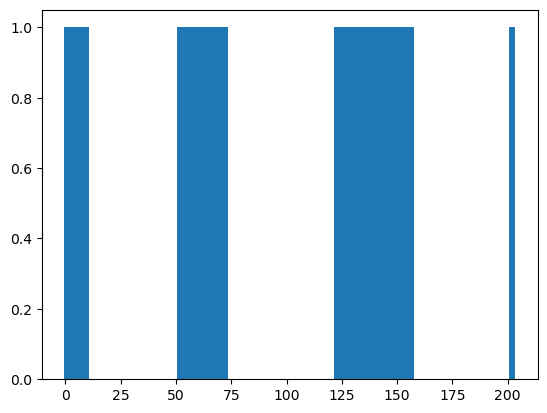

1


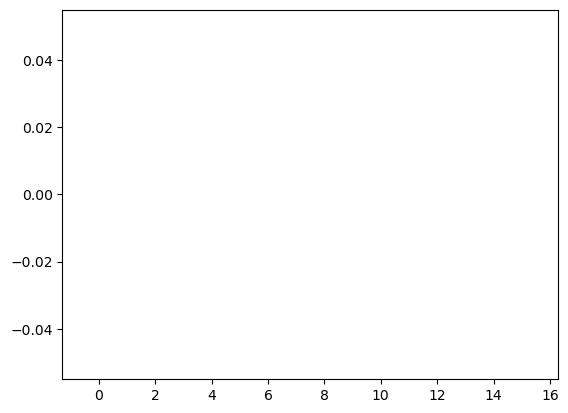

2


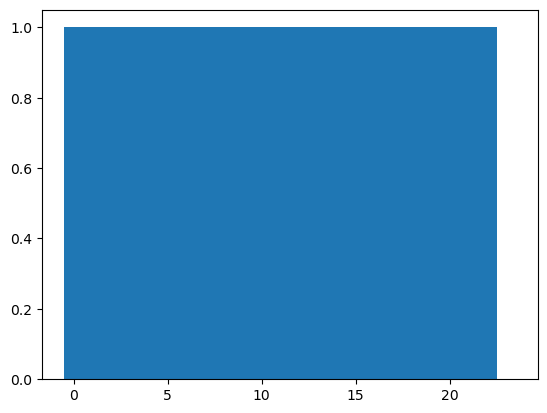

3


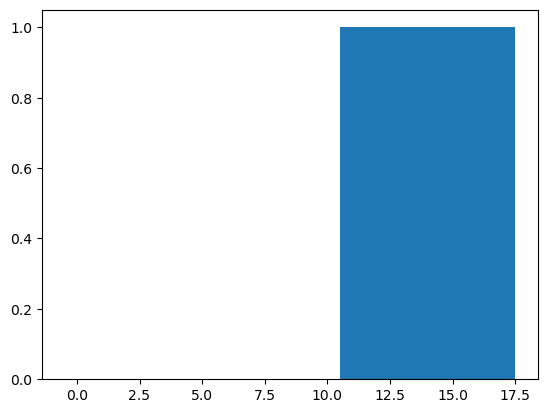

4


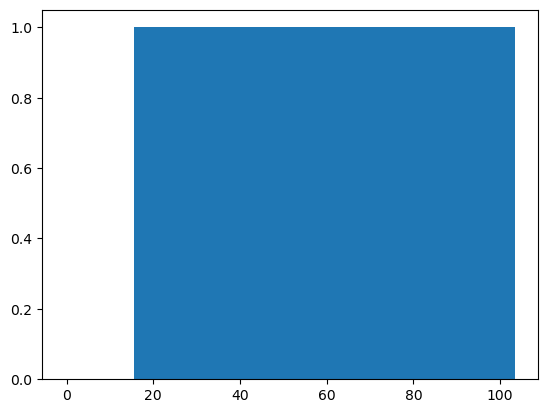

5


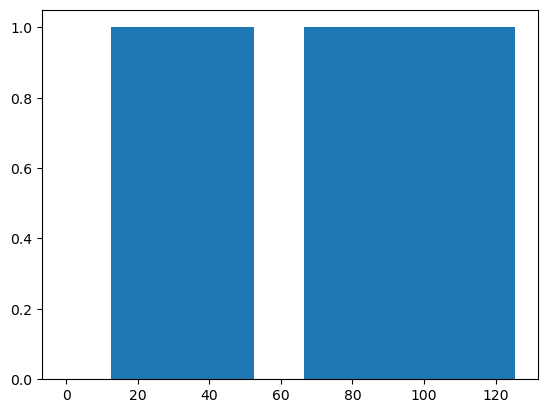

6


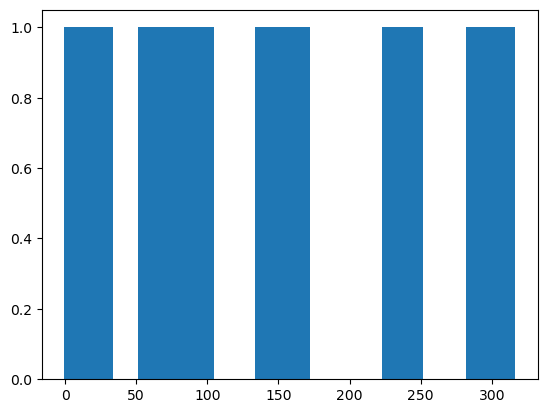

7


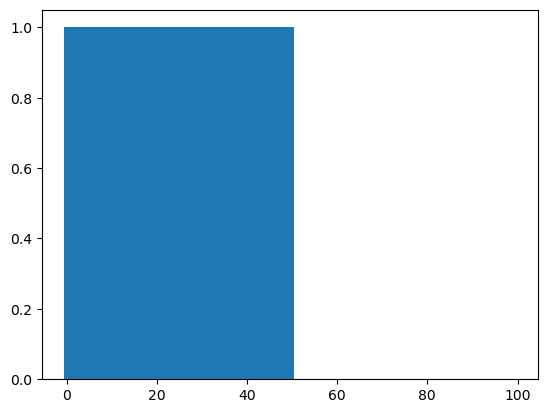

8


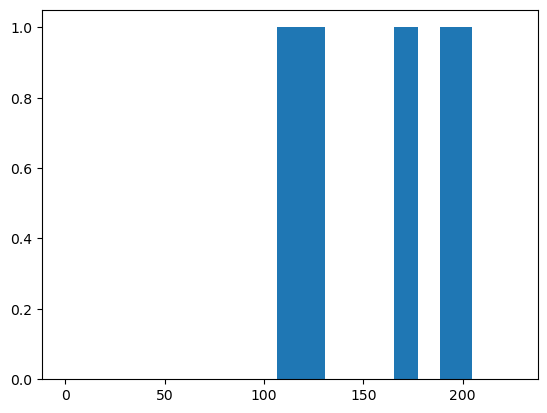

9


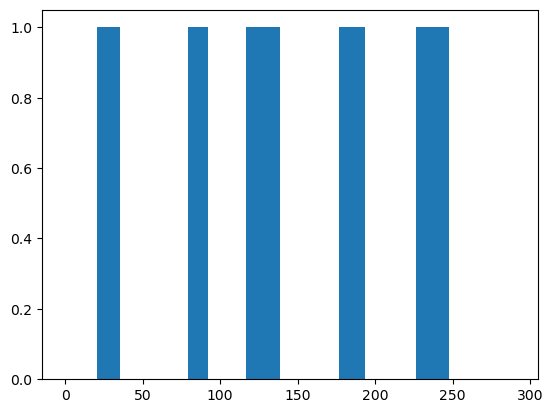

10


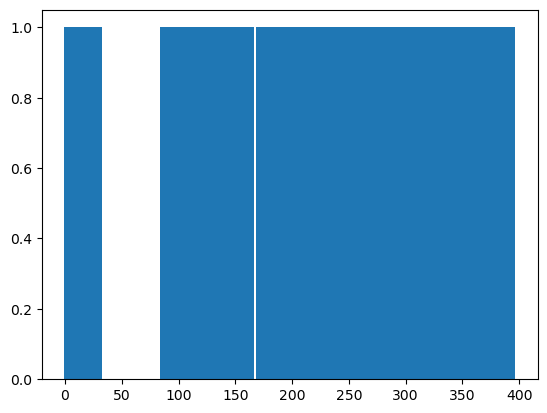

11


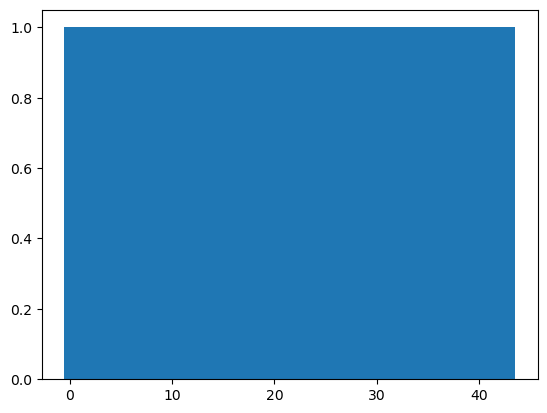

12


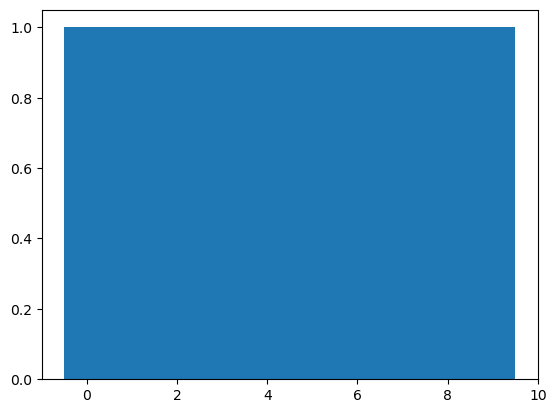

13


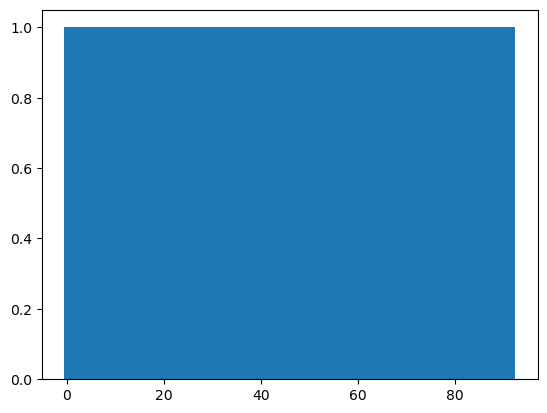

14


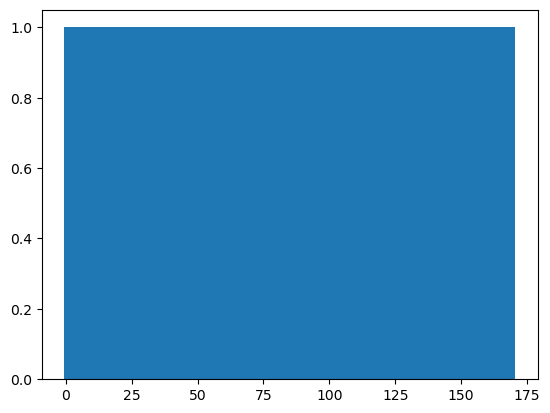

15


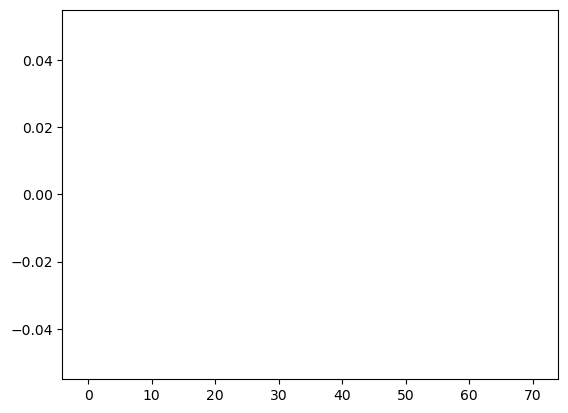

16


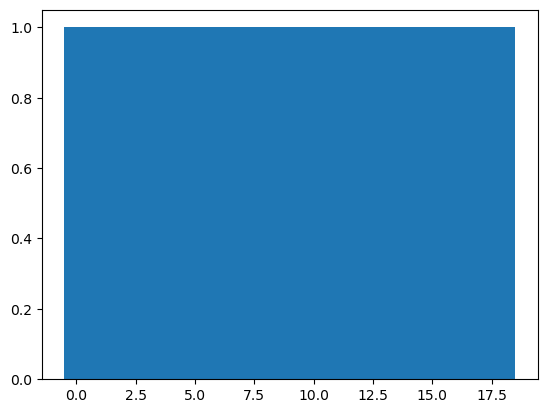

17


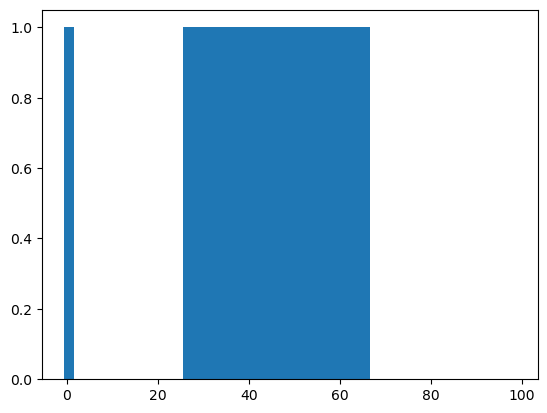

18


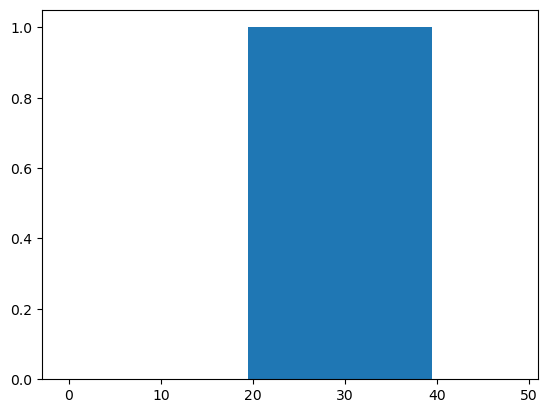

19


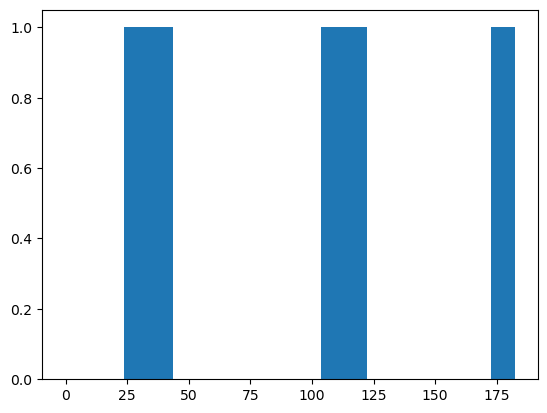

20


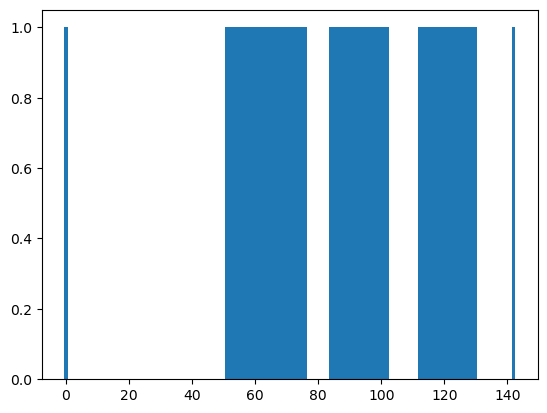

21


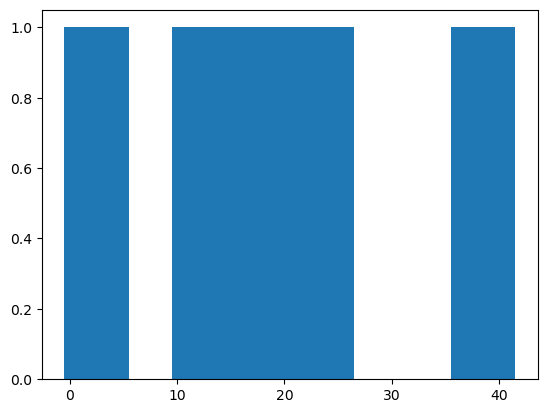

22


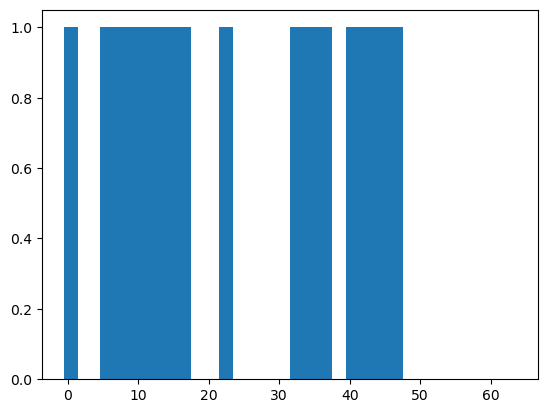

23


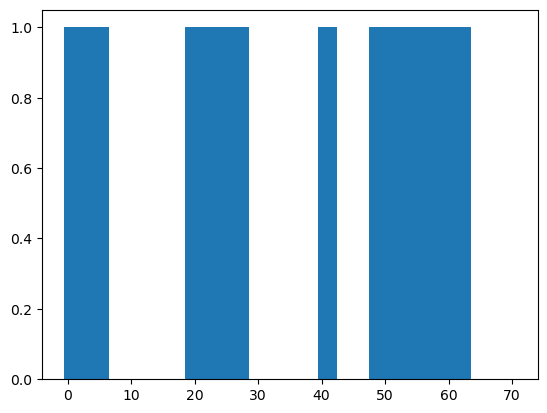

24


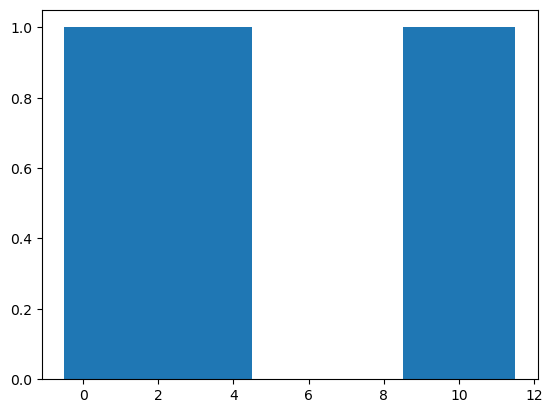

25


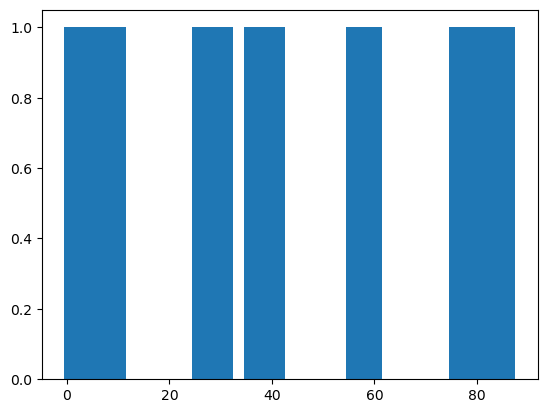

26


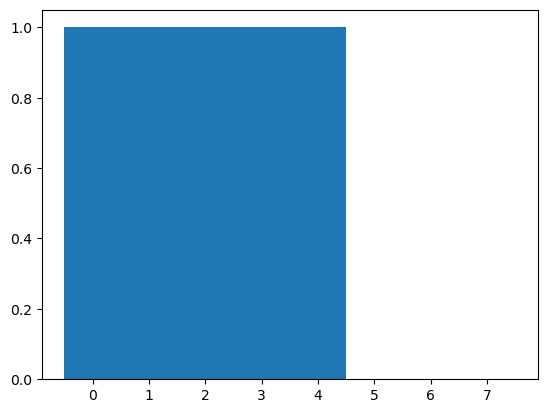

27


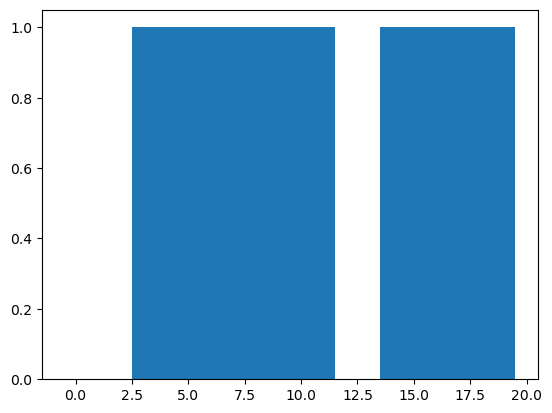

28


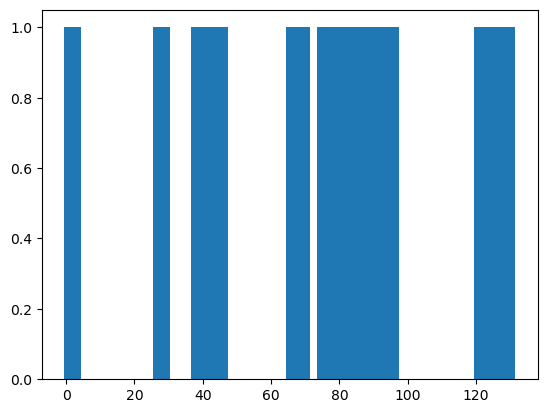

29


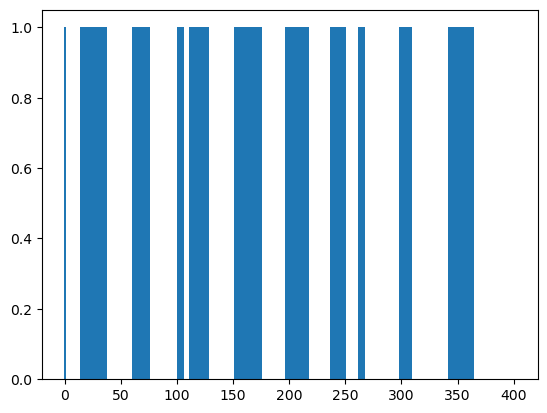

30


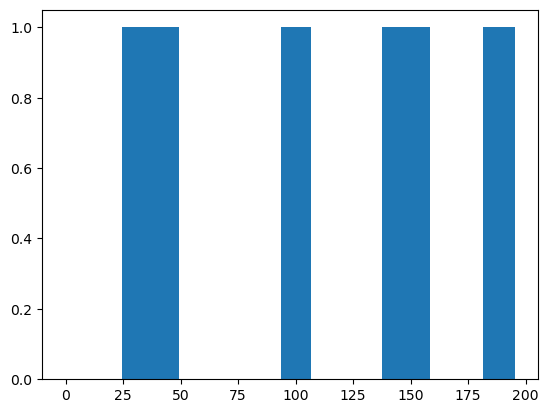

31


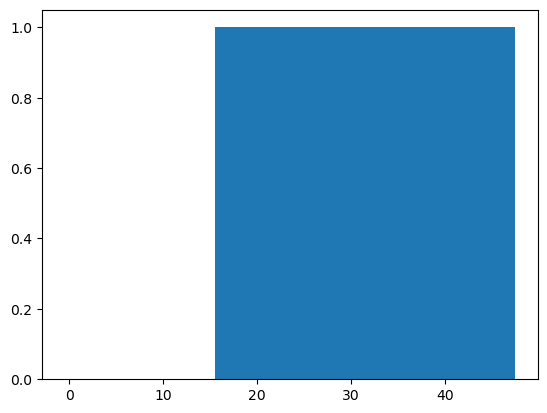

32


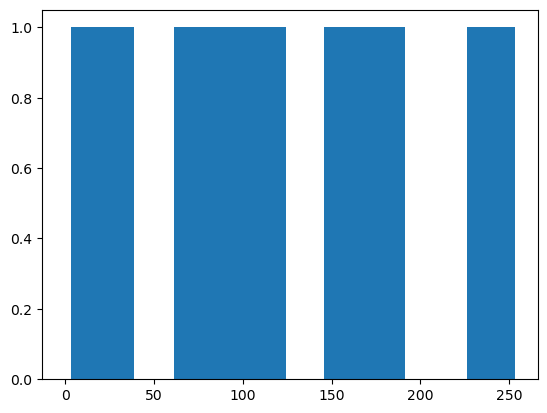

33


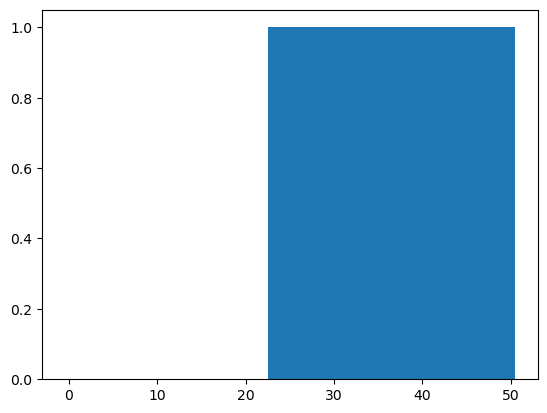

34


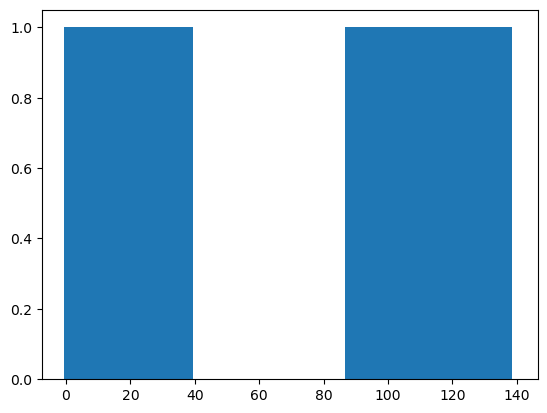

35


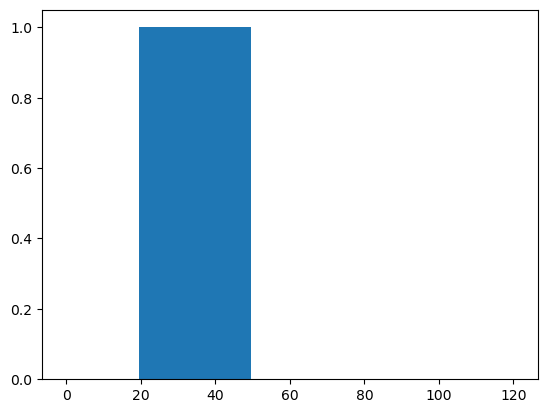

36


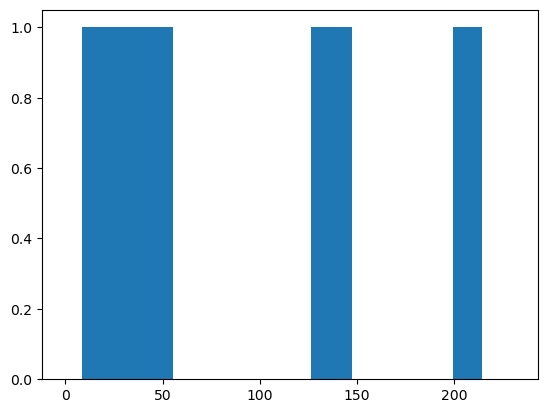

37


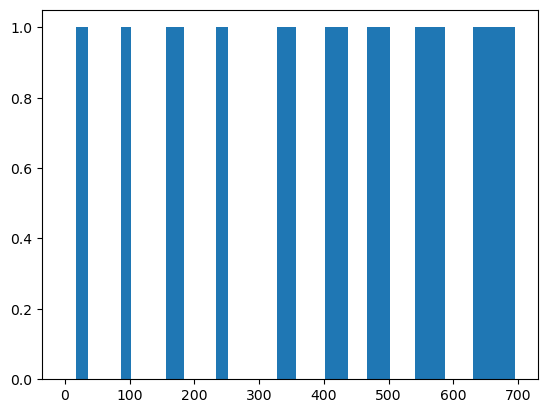

38


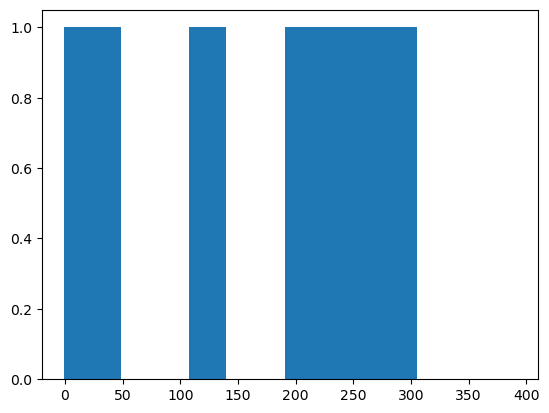

39


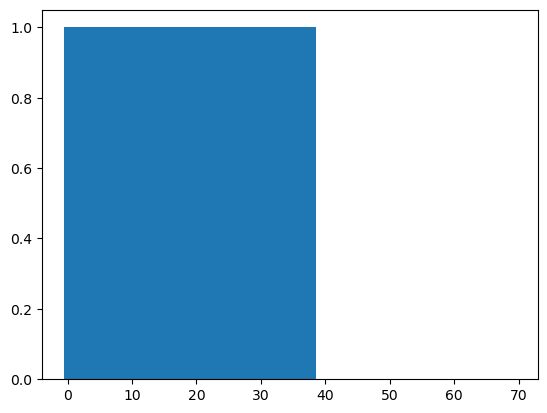

40


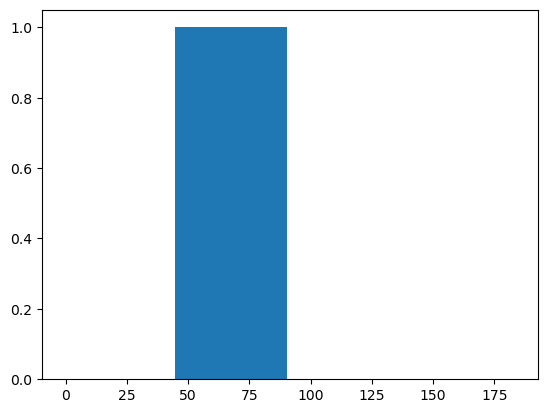

41


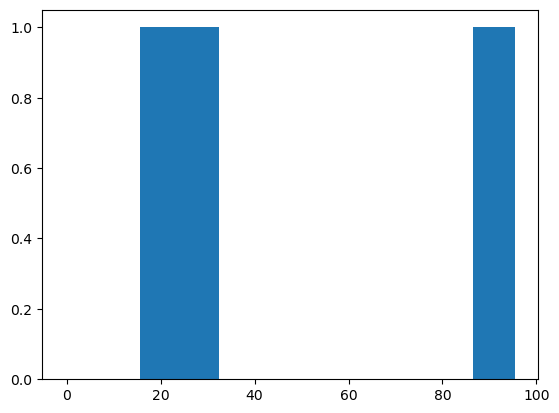

42


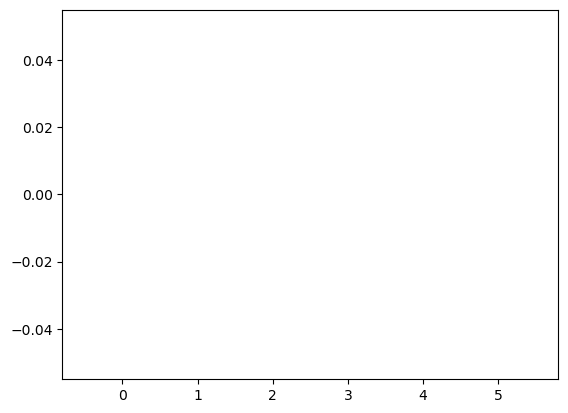

43


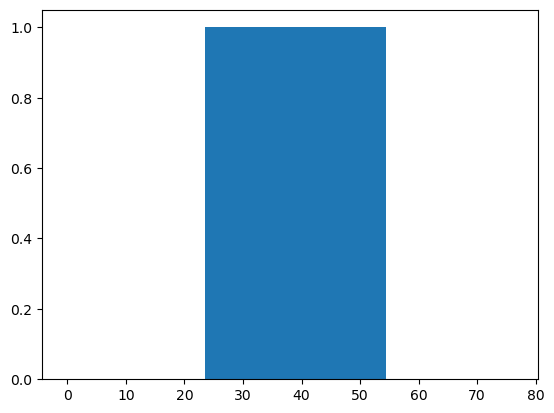

44


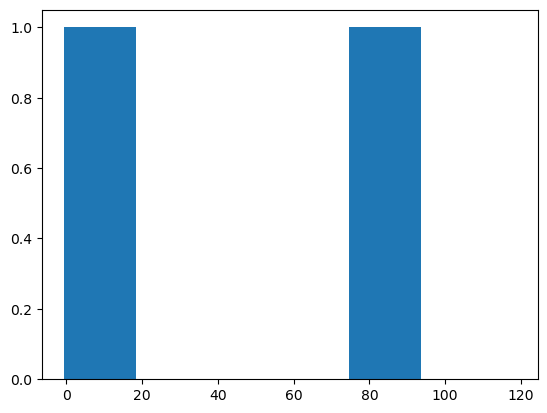

45


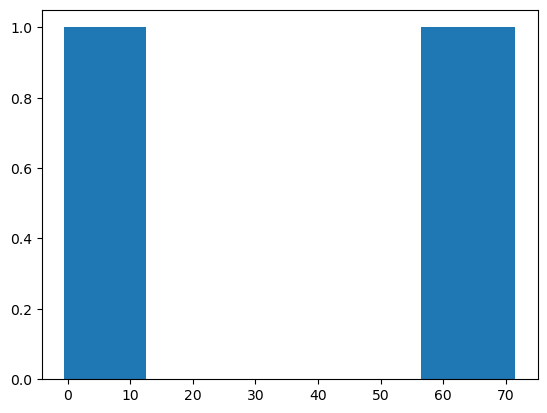

46


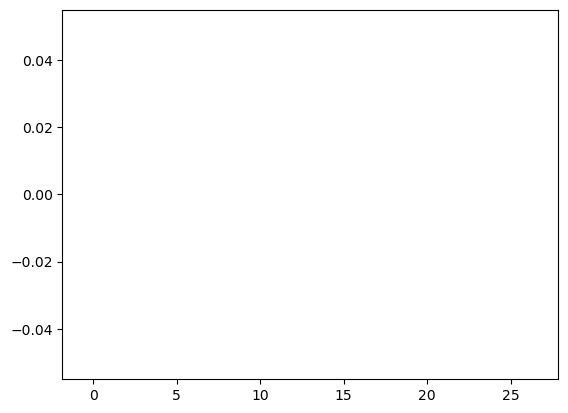

47


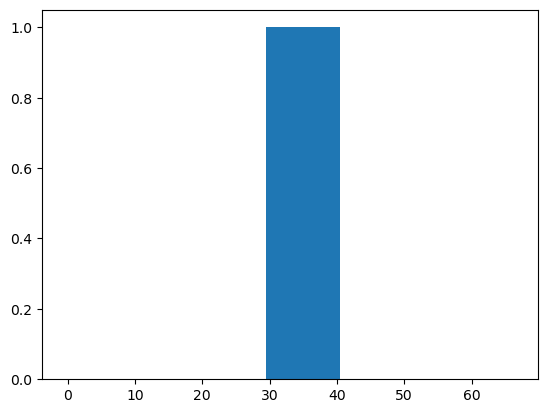

48


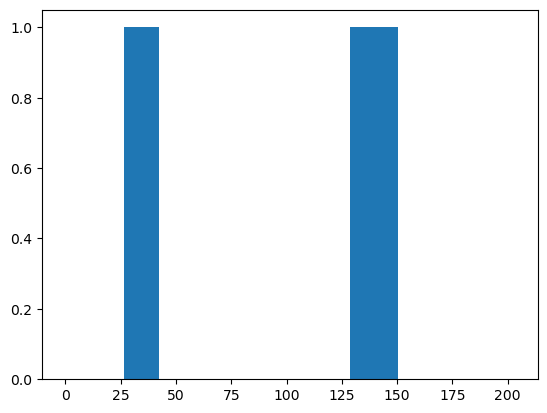

49


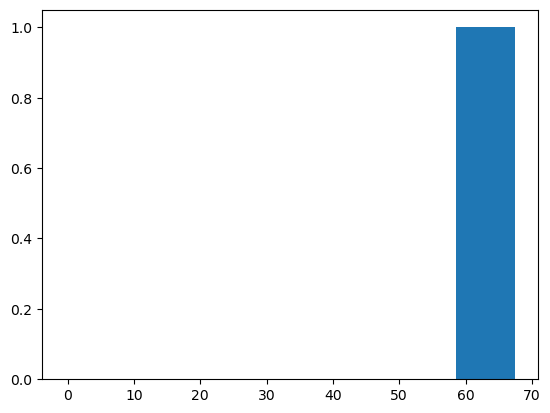

50


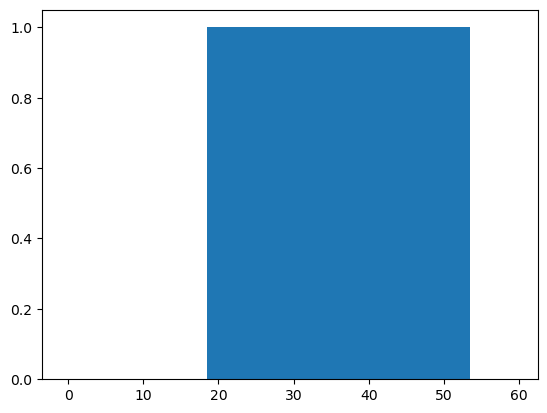

51


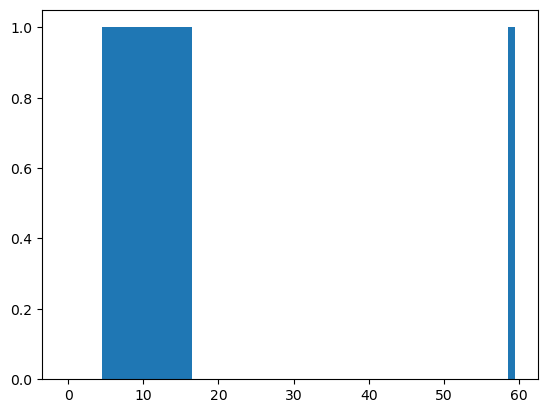

52


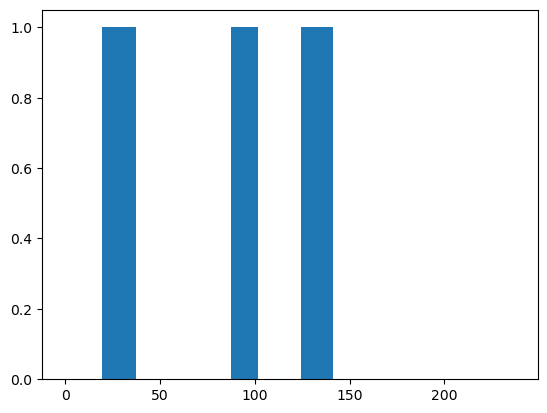

53


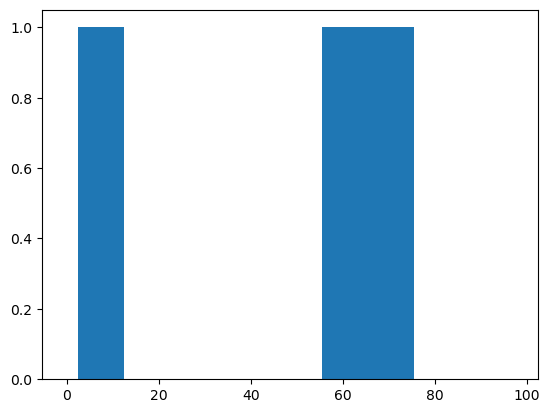

54


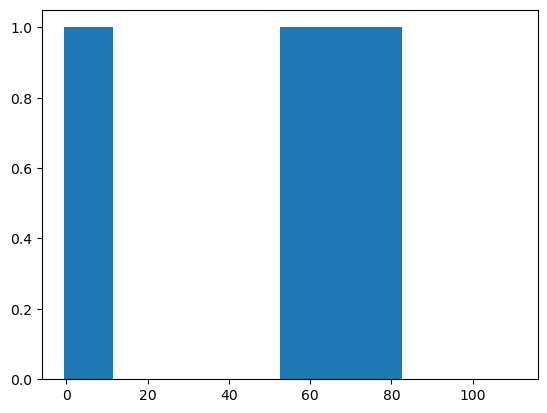

55


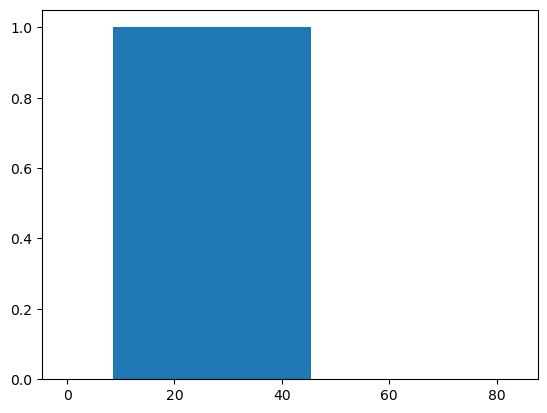

56


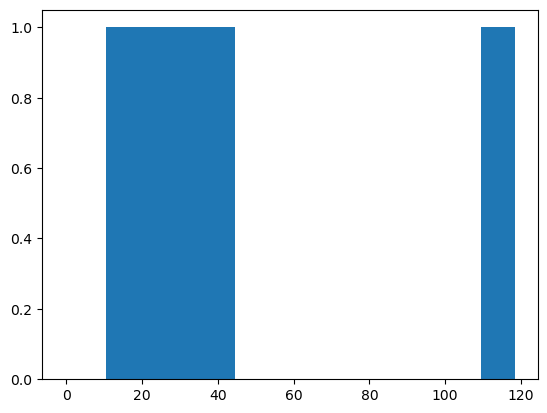

57


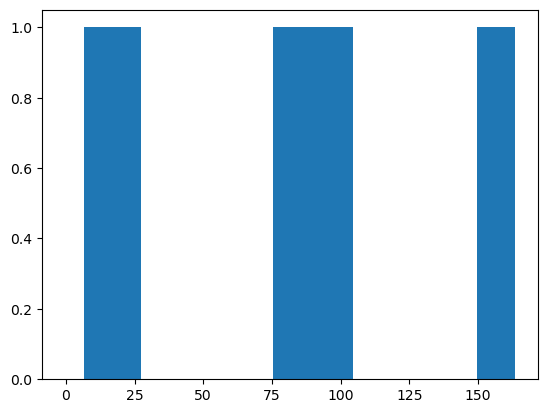

58


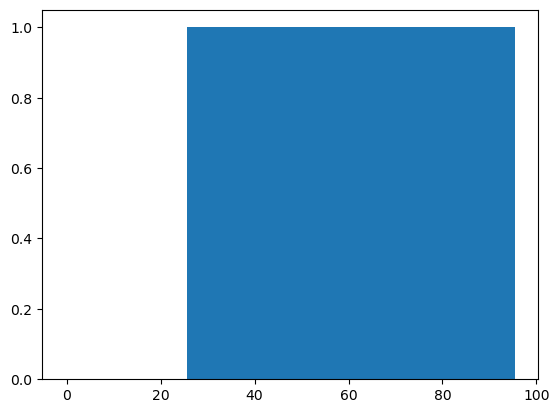

59


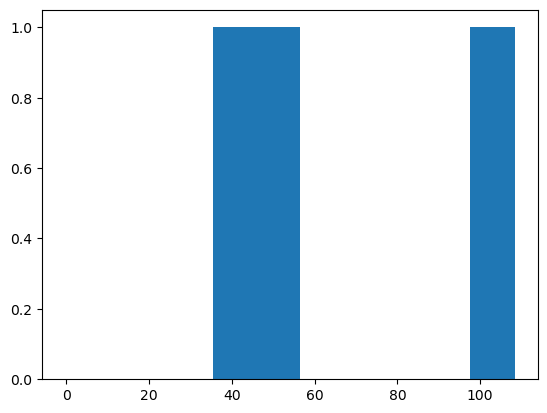

60


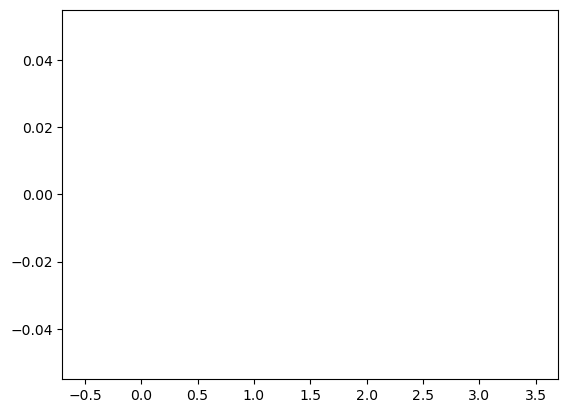

61


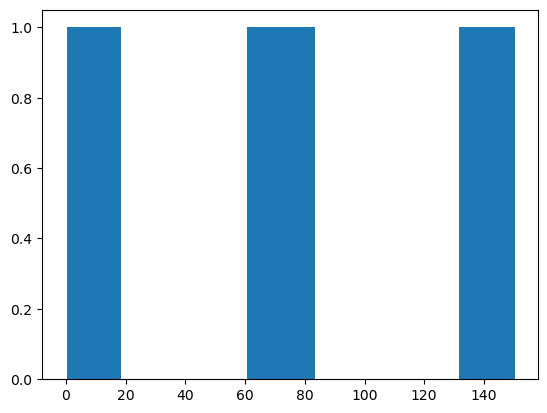

62


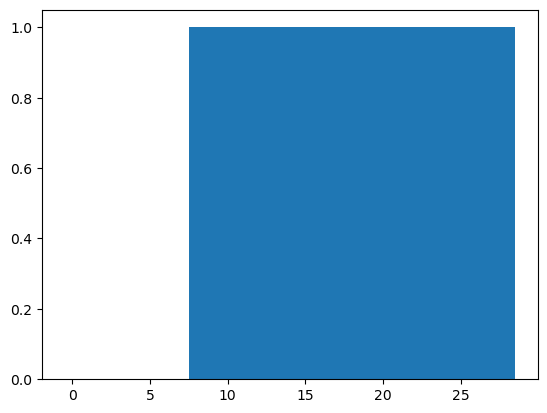

63


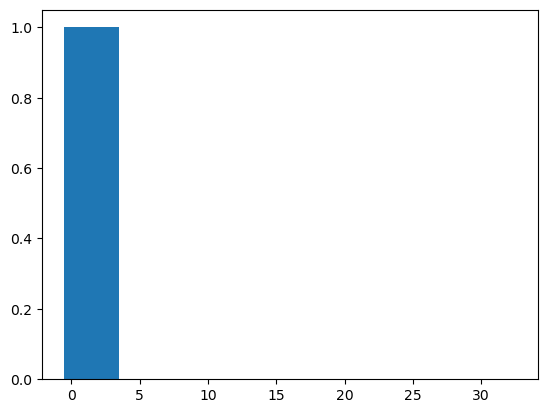

64


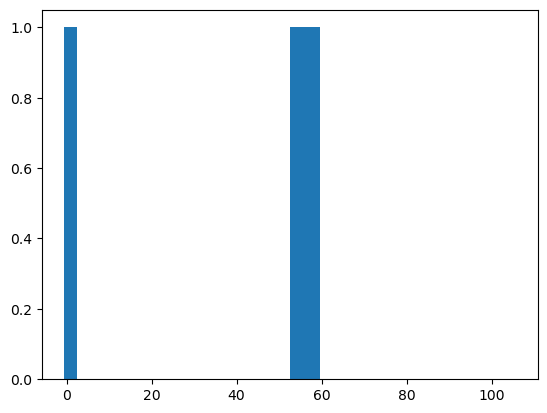

65


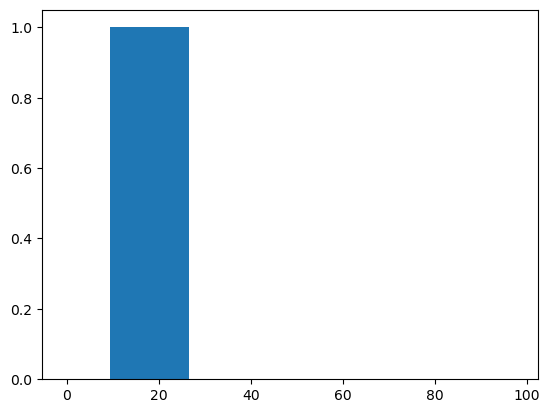

66


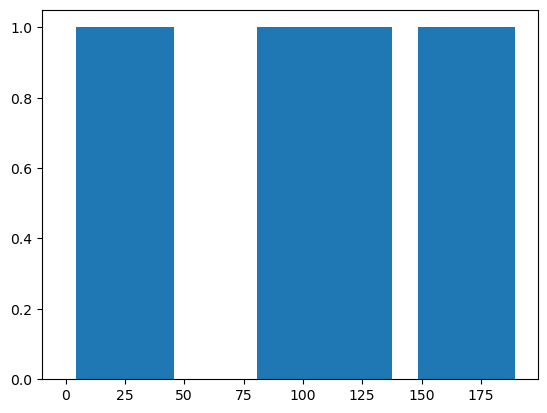

67


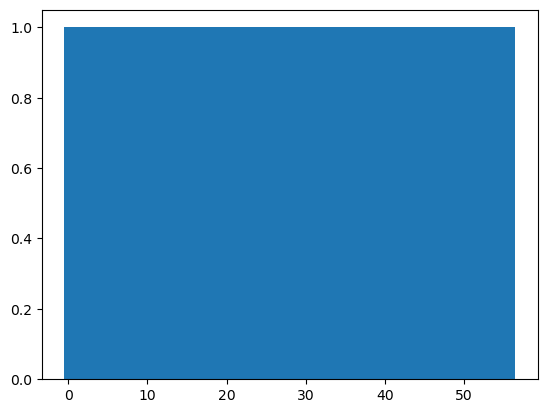

68


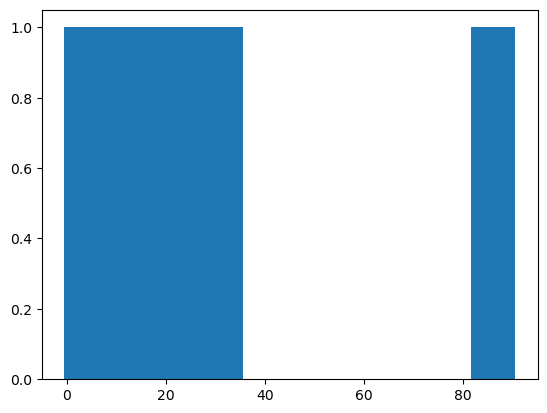

69


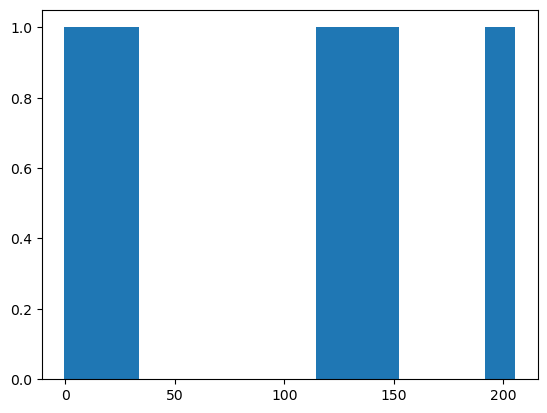

70


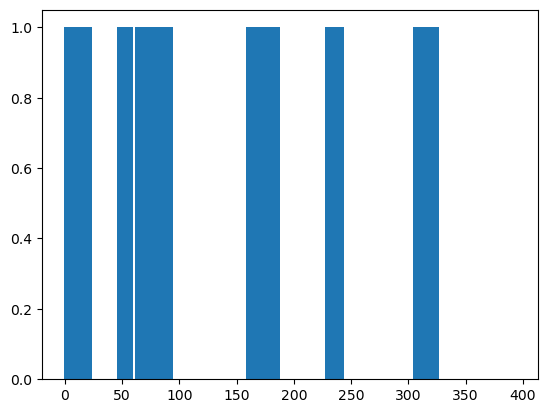

71


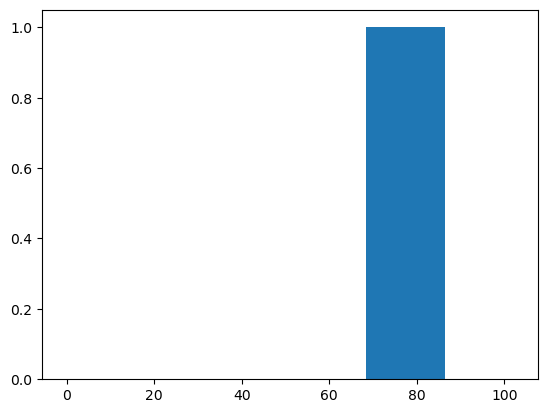

72


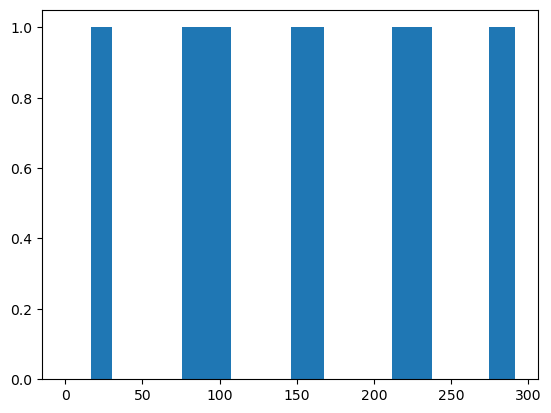

73


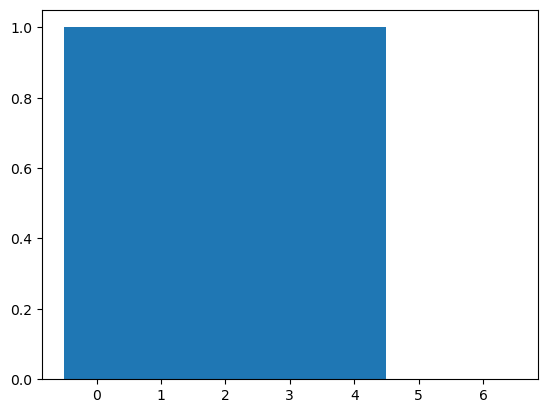

74


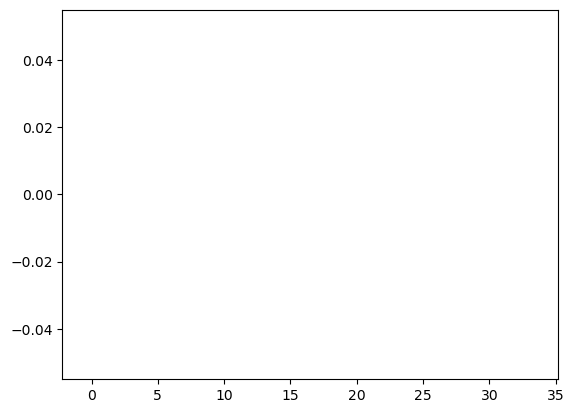

75


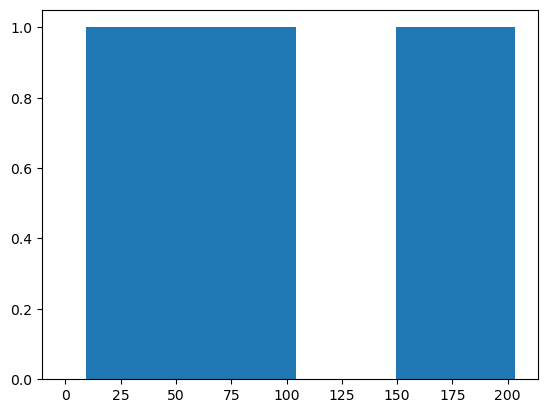

76


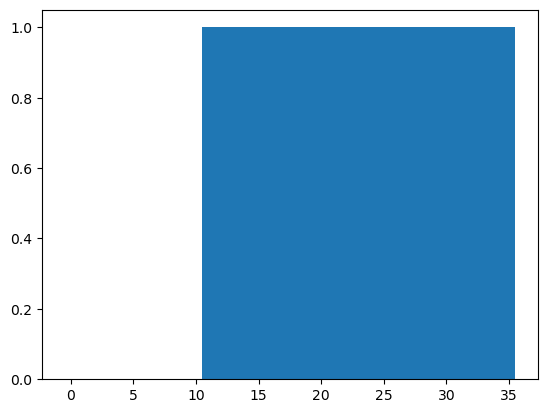

77


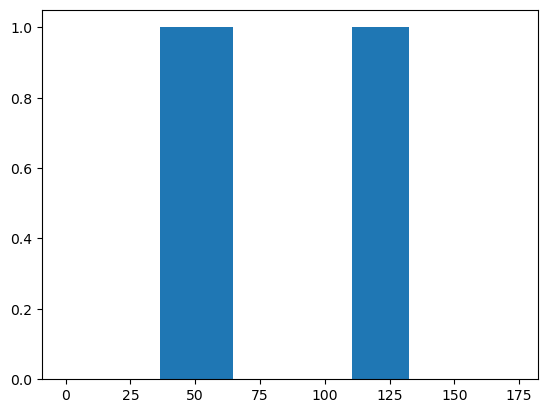

78


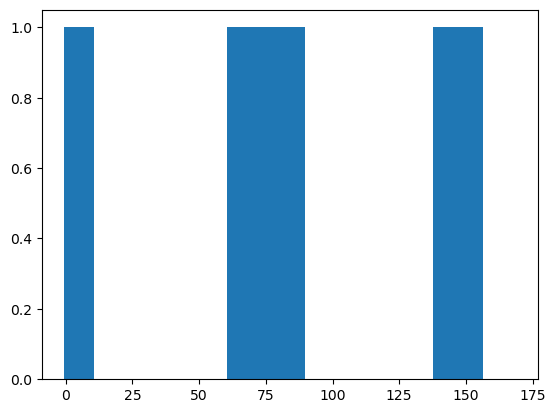

79


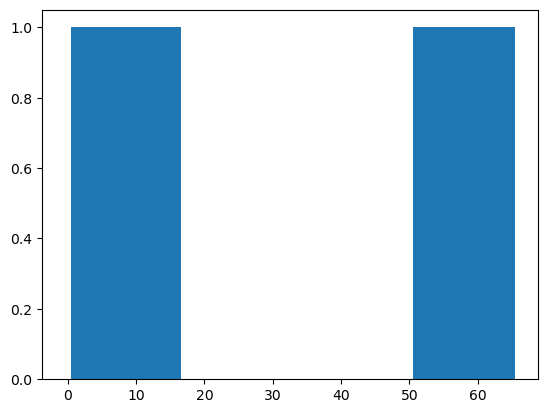

80


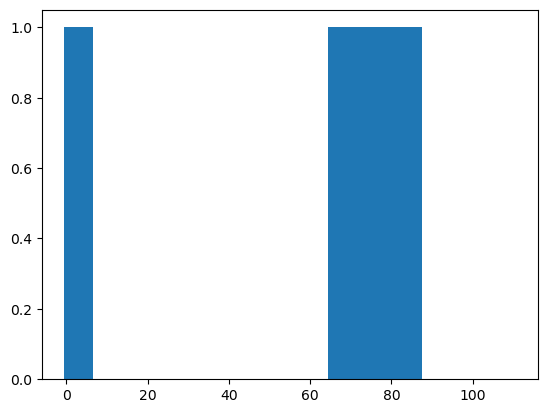

81


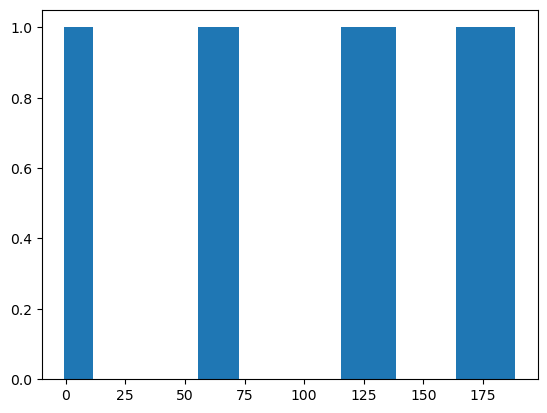

82


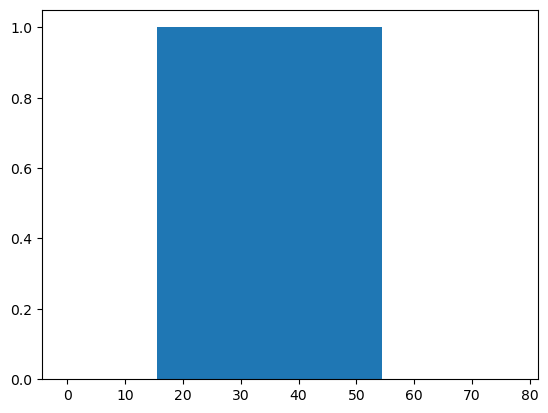

83


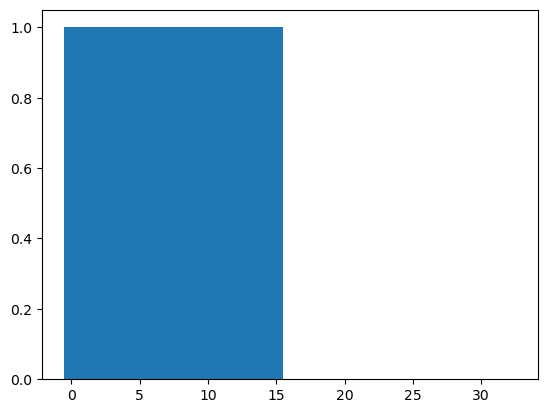

84


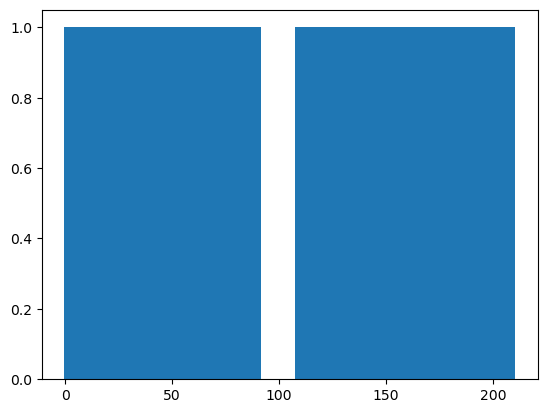

85


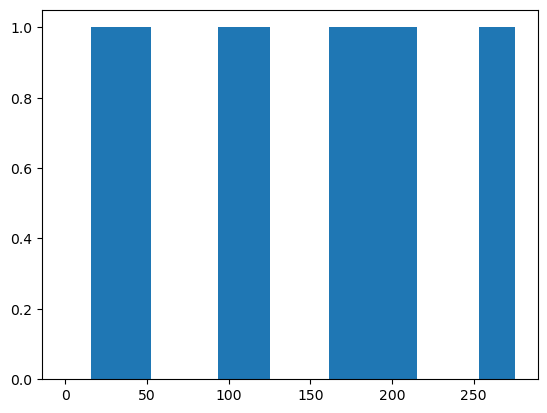

86


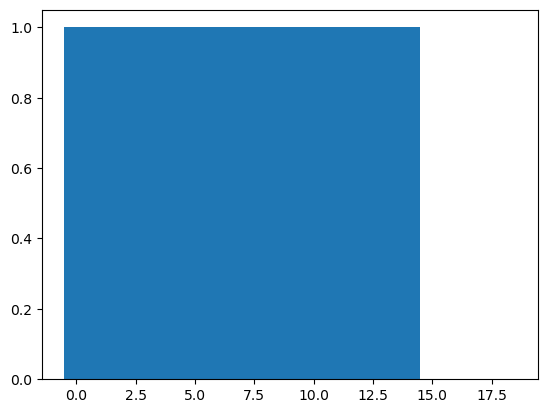

87


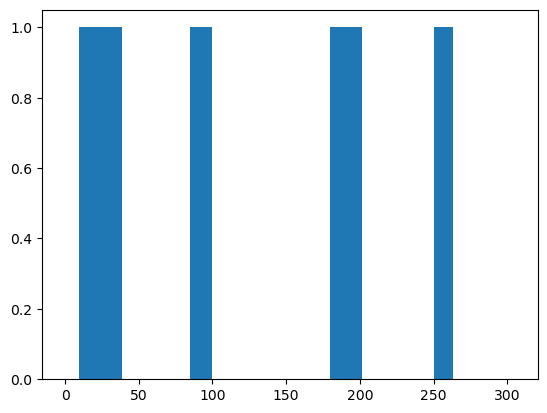

88


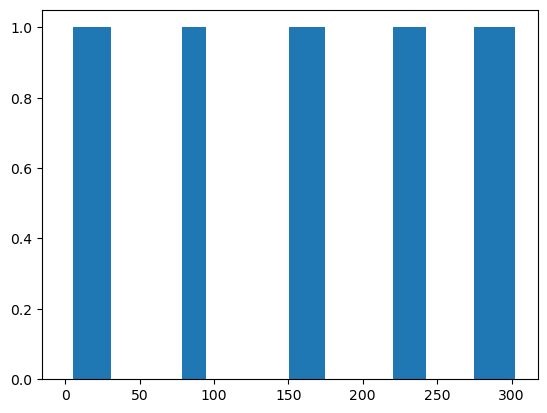

89


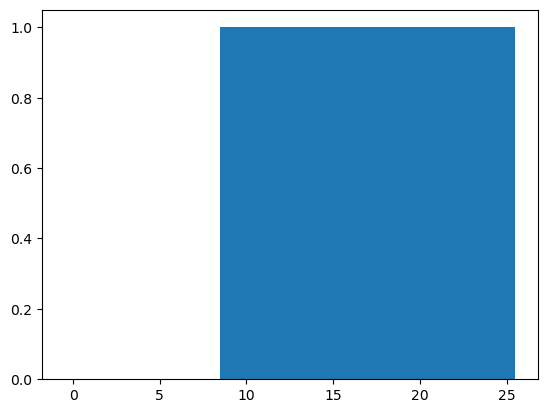

90


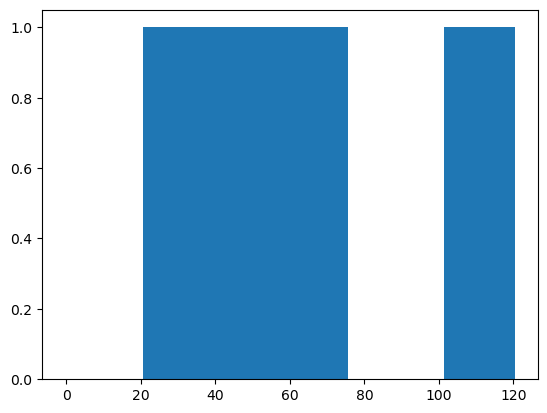

91


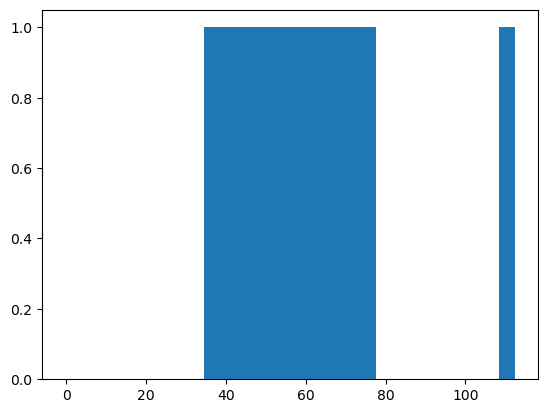

92


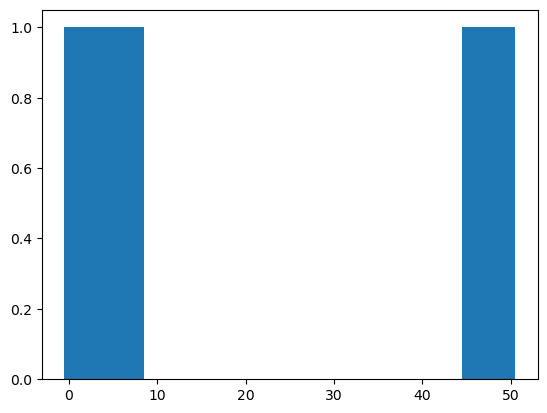

93


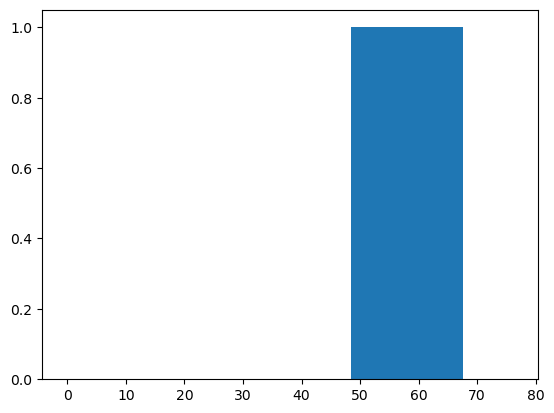

94


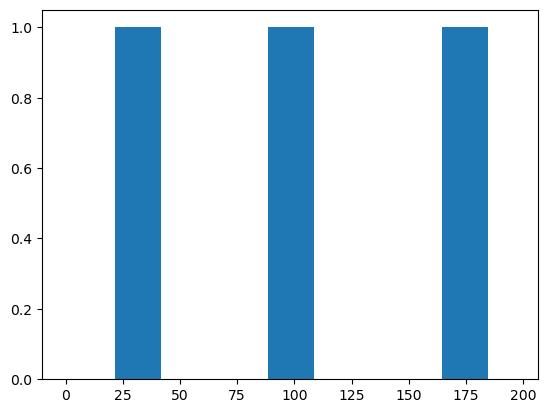

95


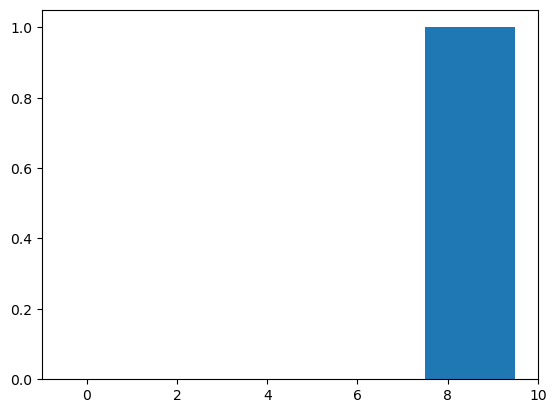

96


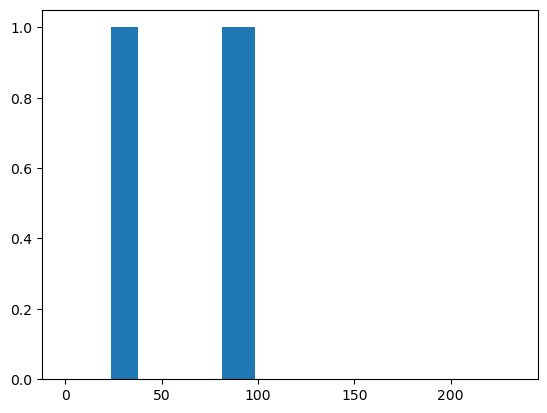

97


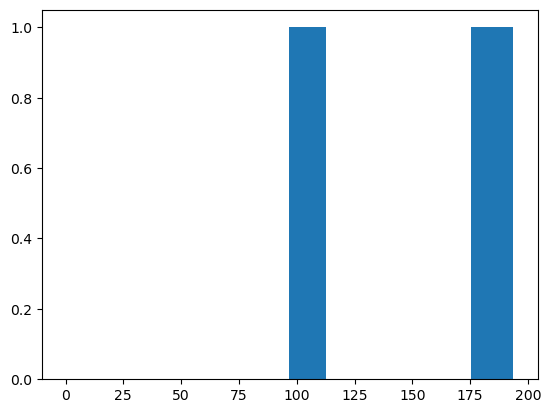

98


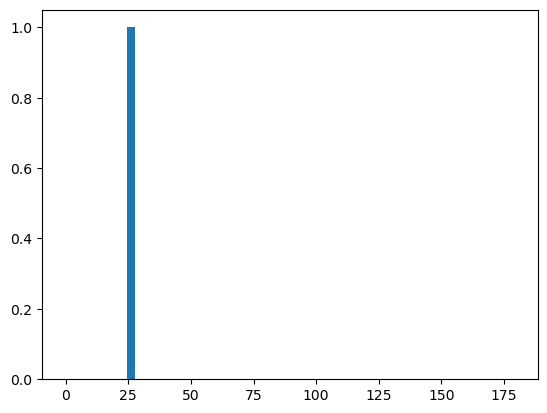

99


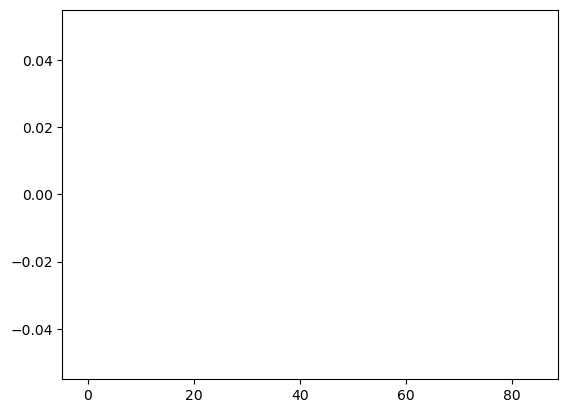

100


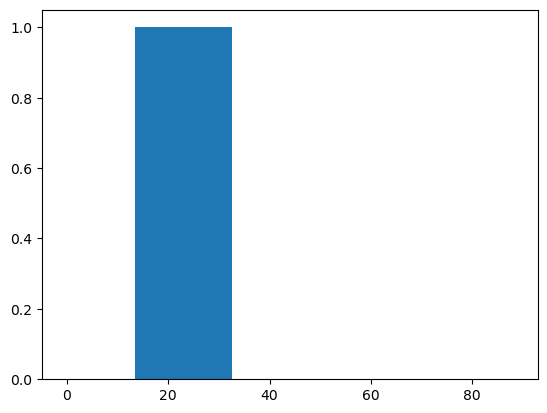

101


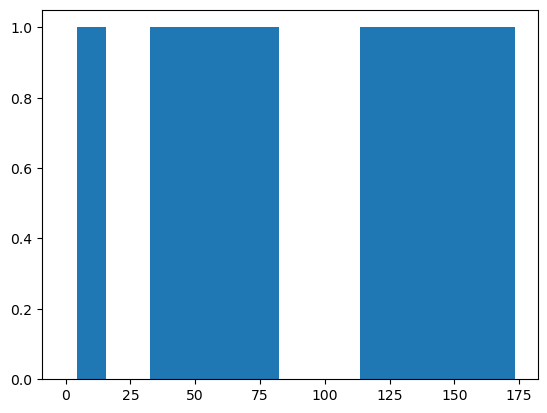

102


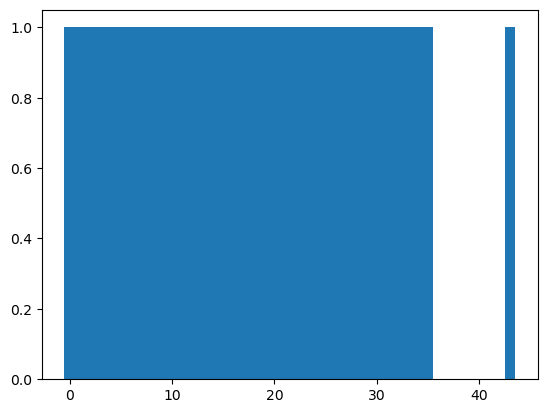

103


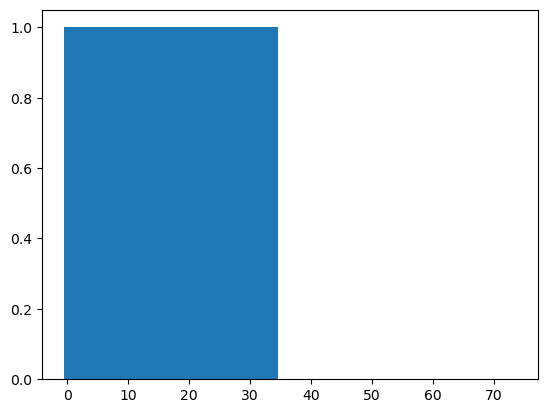

104


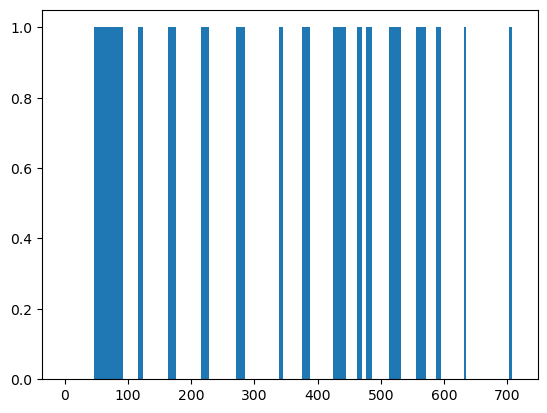

105


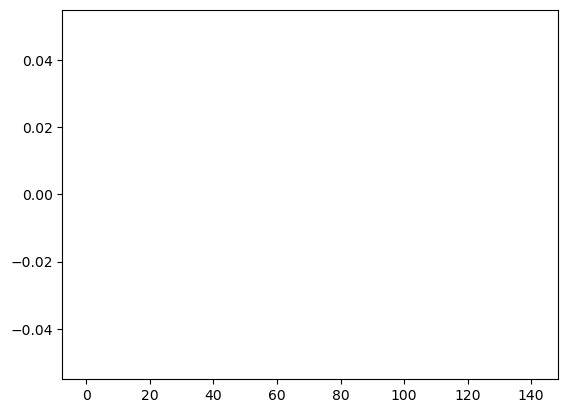

106


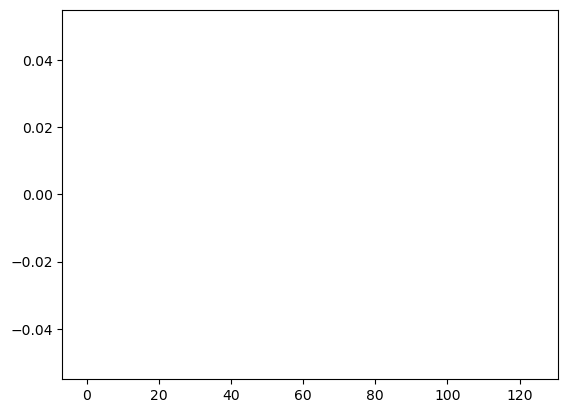

107


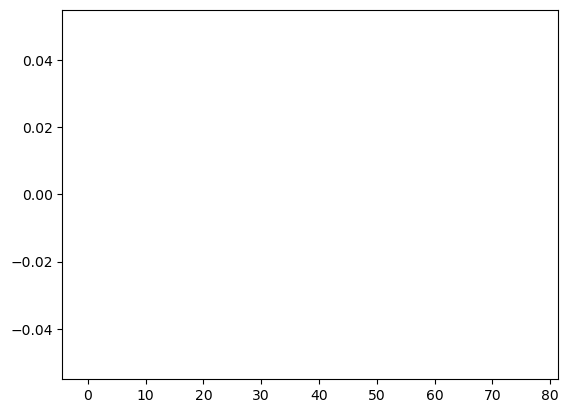

108


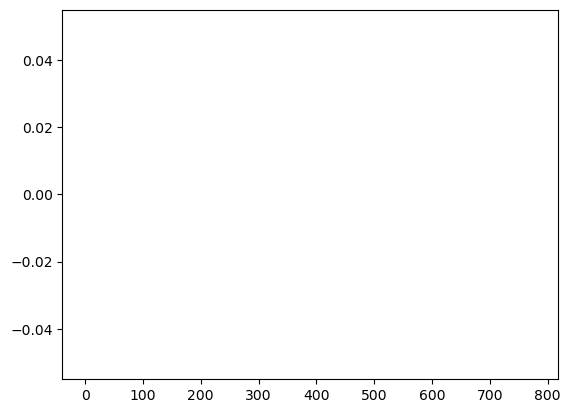

109


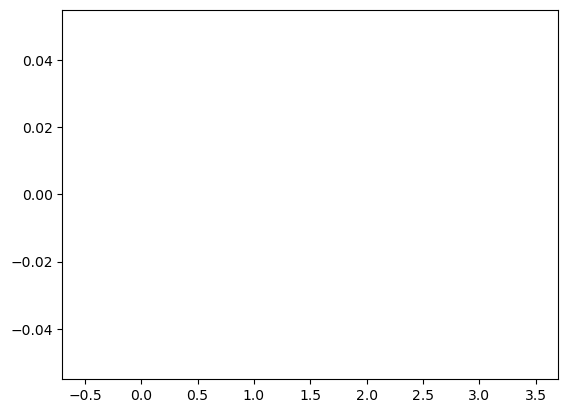

110


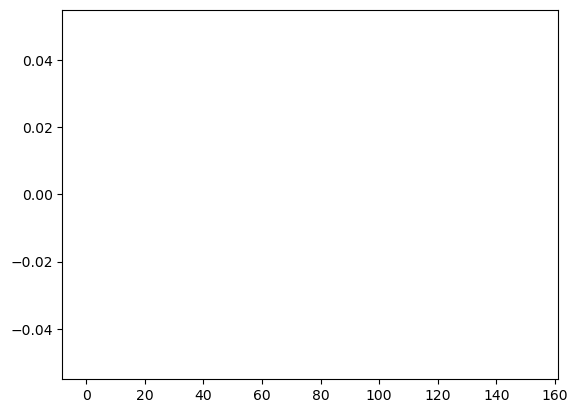

111


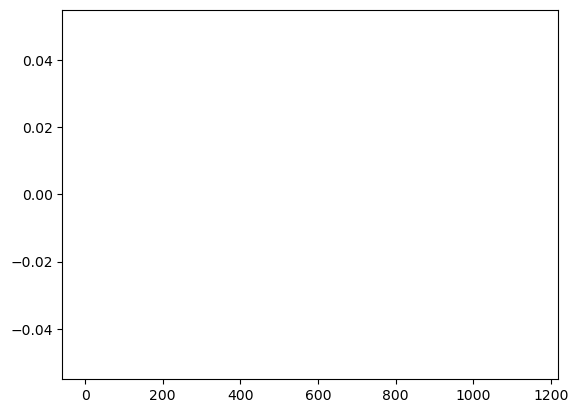

112


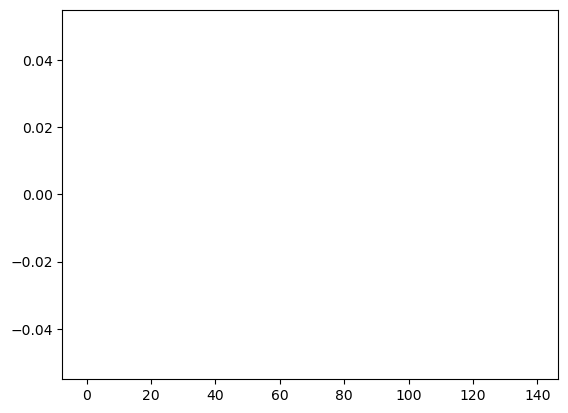

113


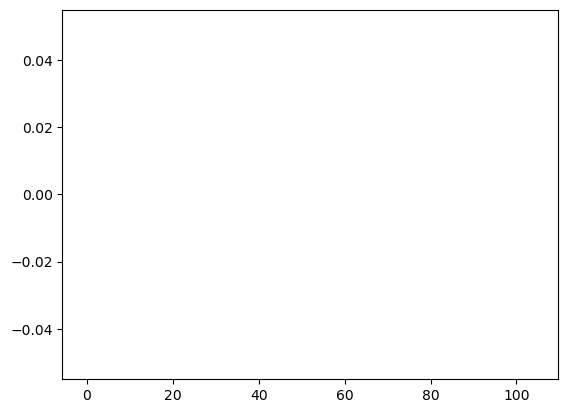

114


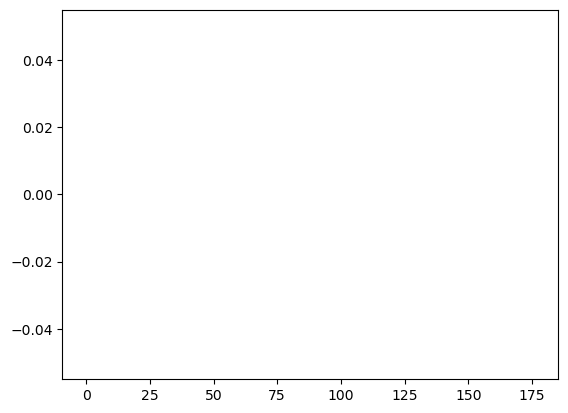

115


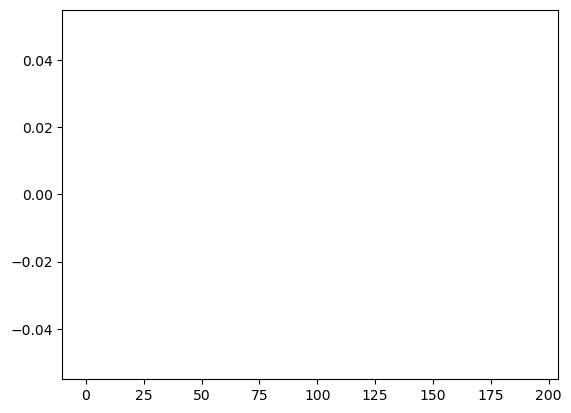

116


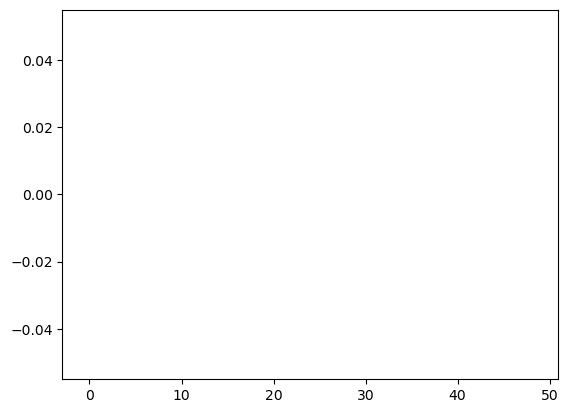

117


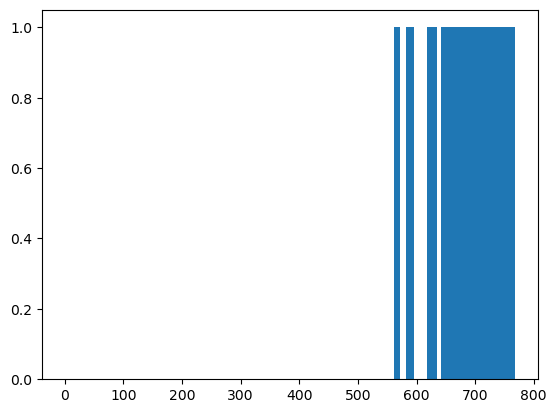

118


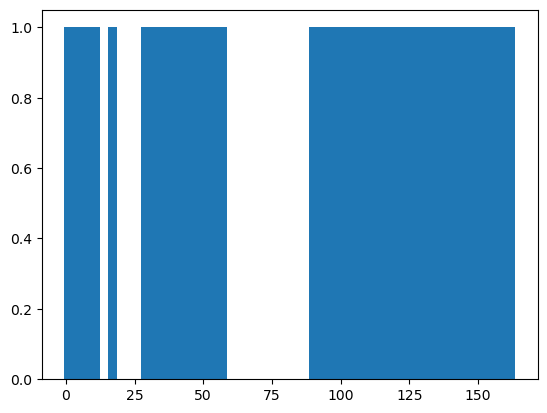

119


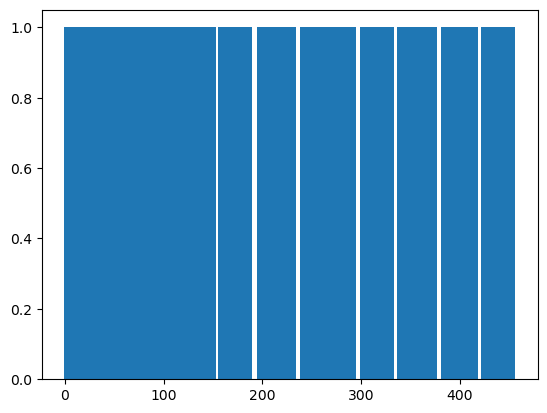

120


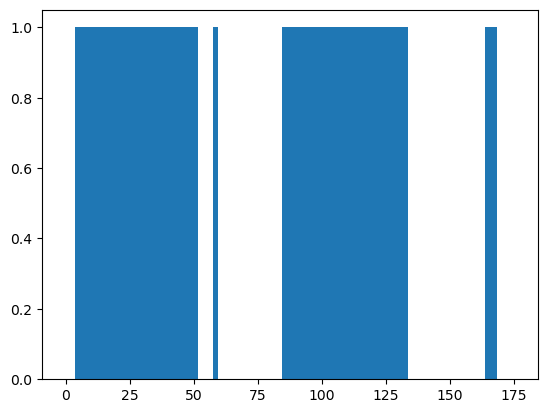

121


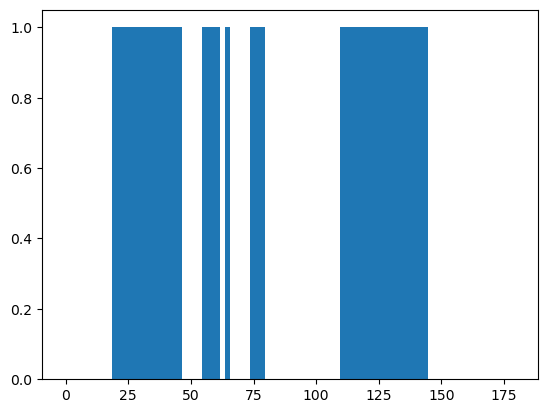

122


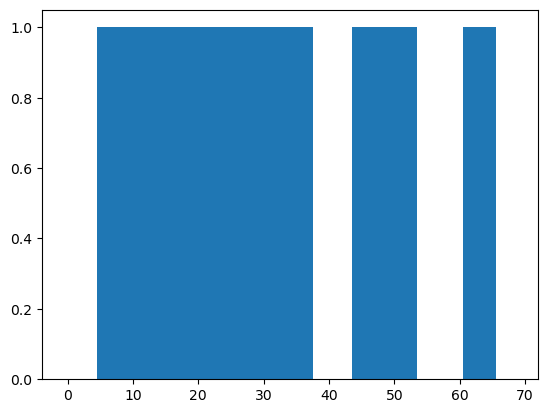

123


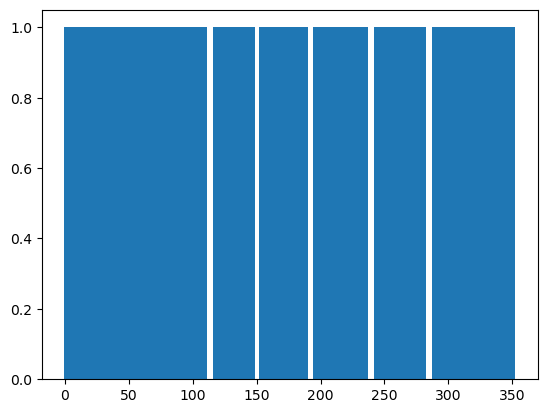

124


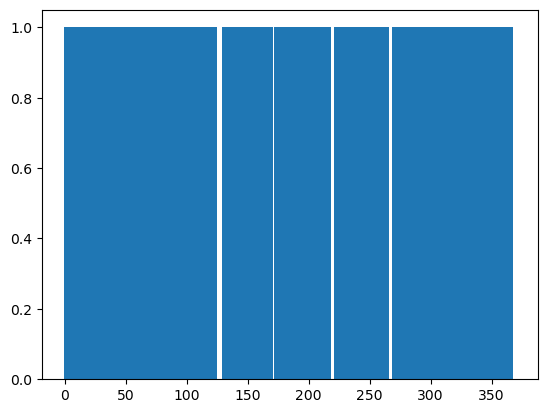

125


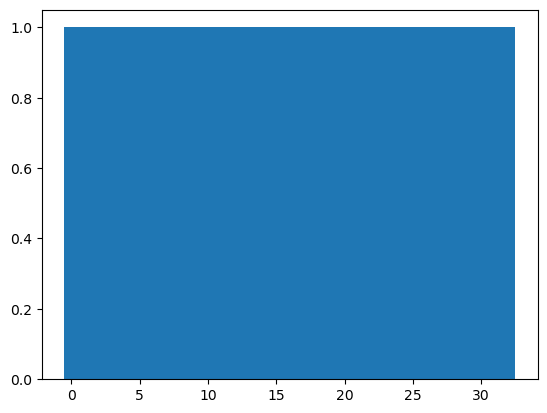

126


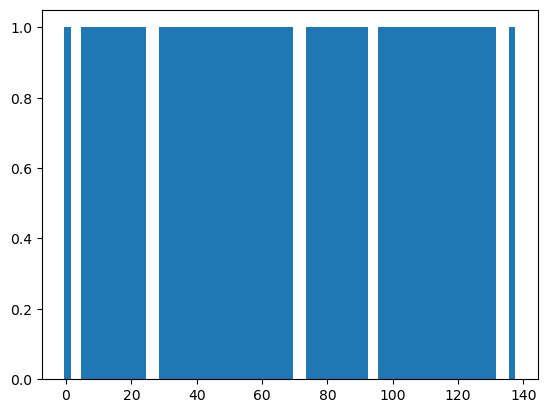

127


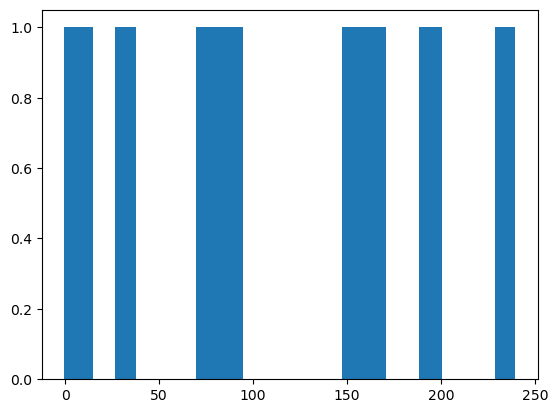

128


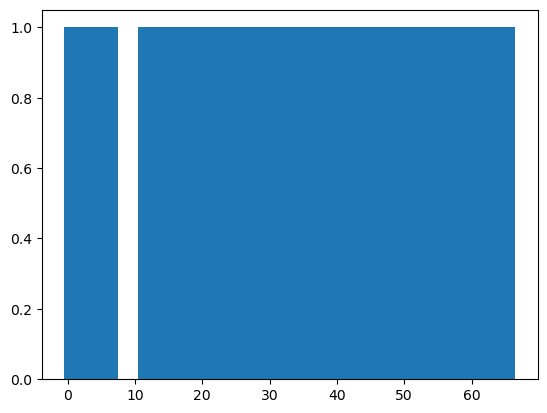

129


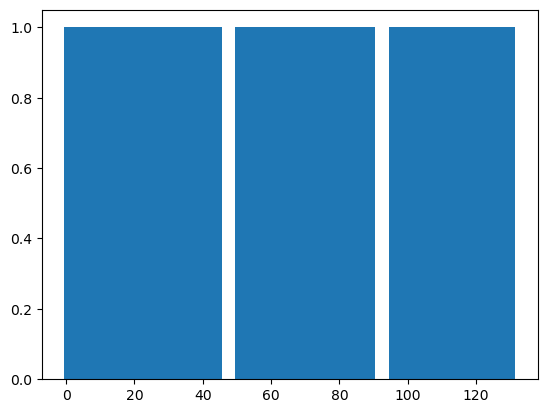

130


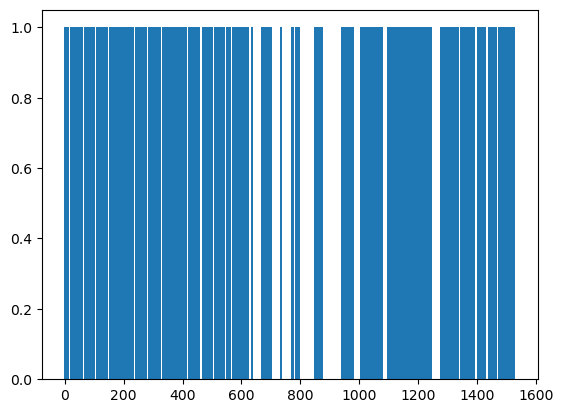

131


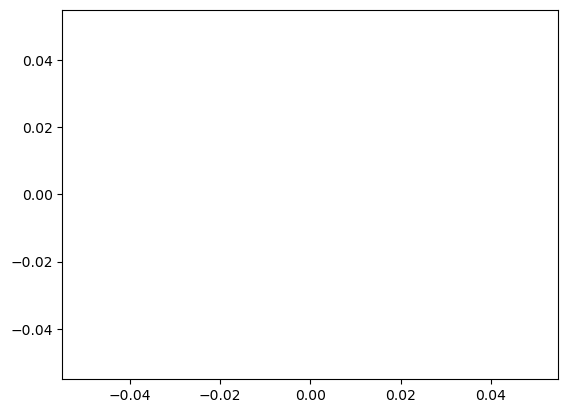

132


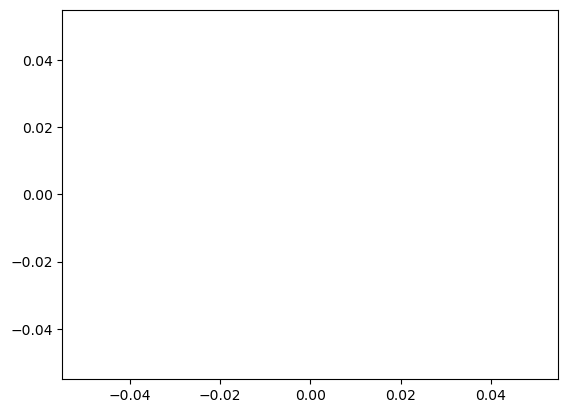

133


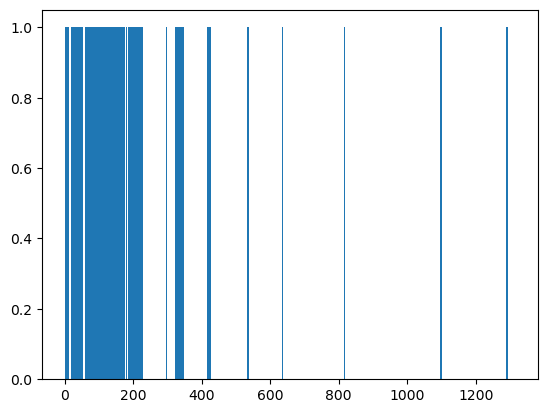

134


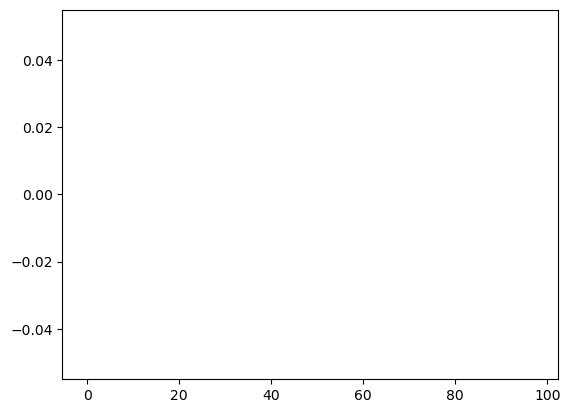

135


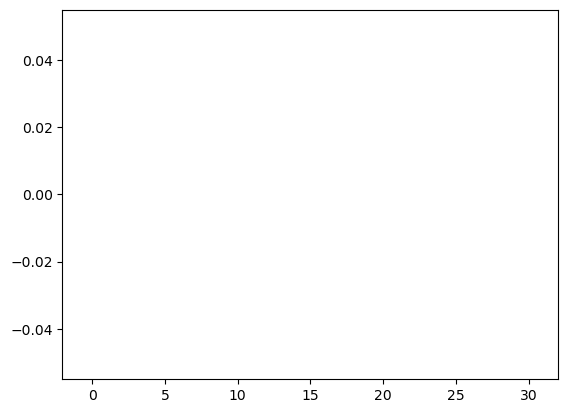

136


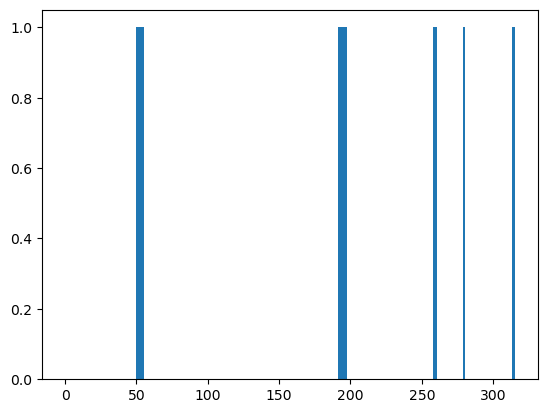

137


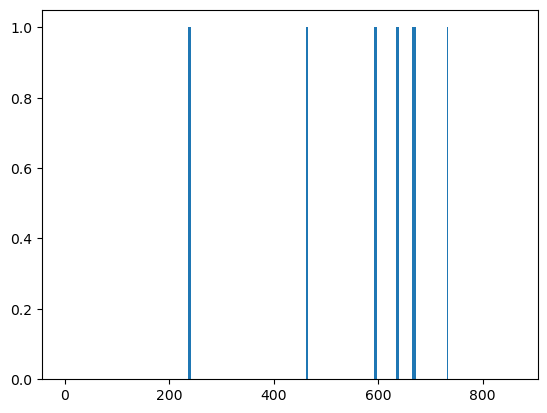

138


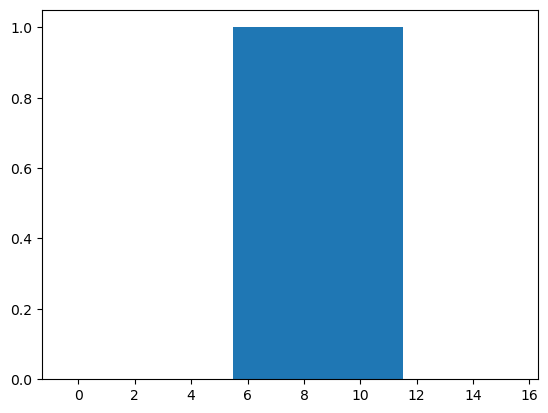

139


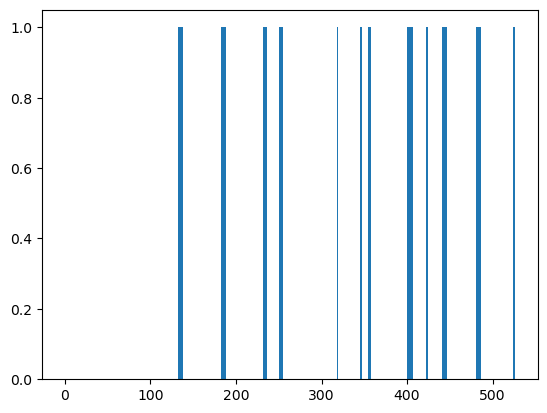

140


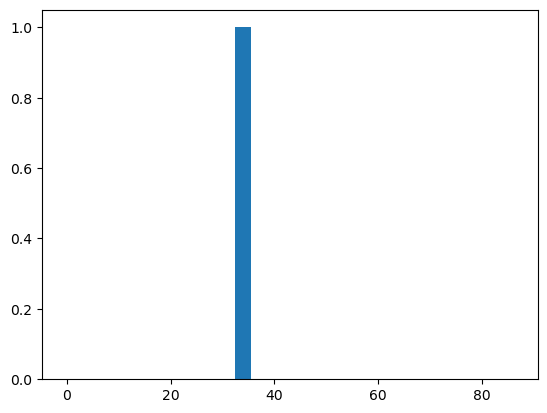

141


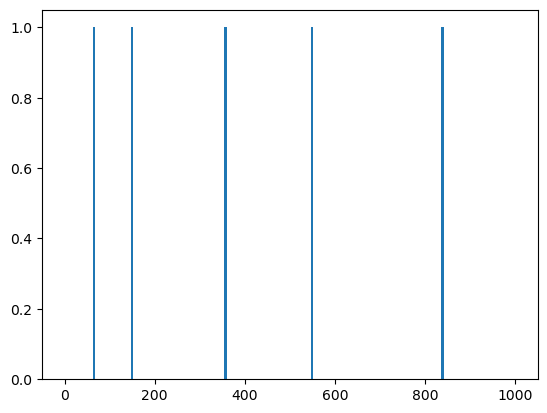

142


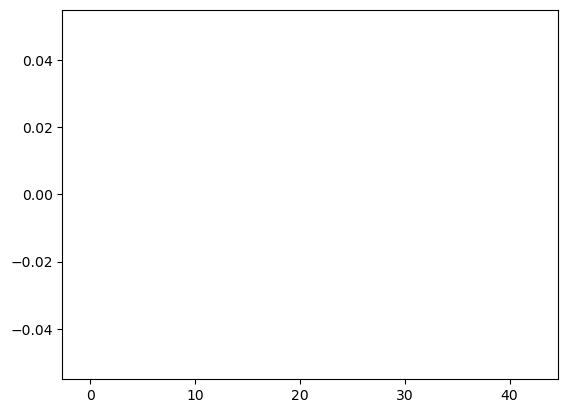

143


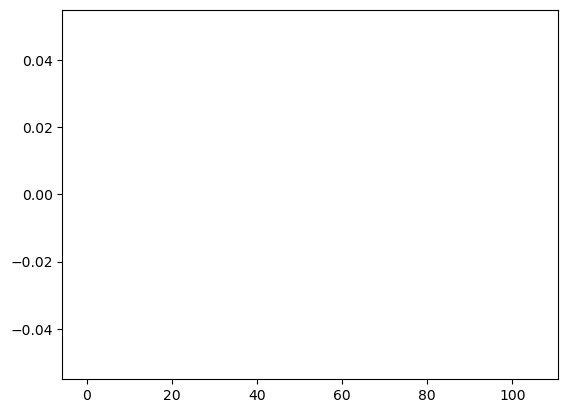

144


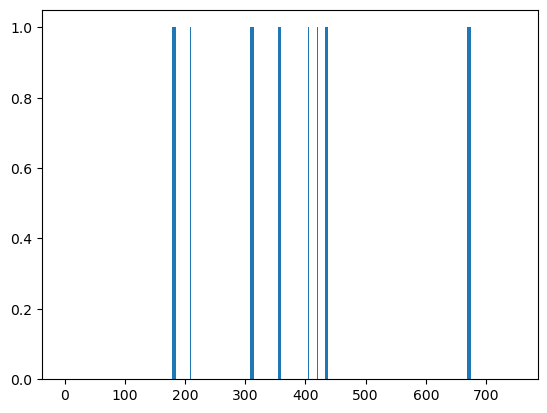

145


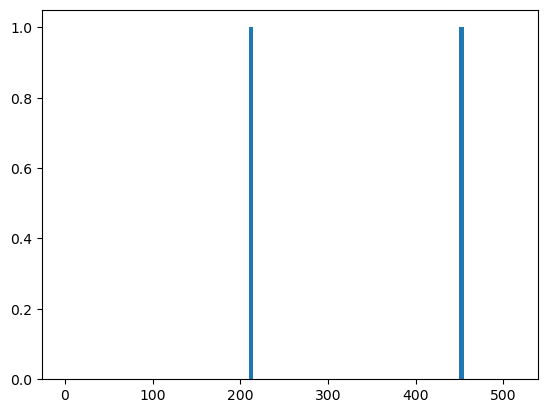

146


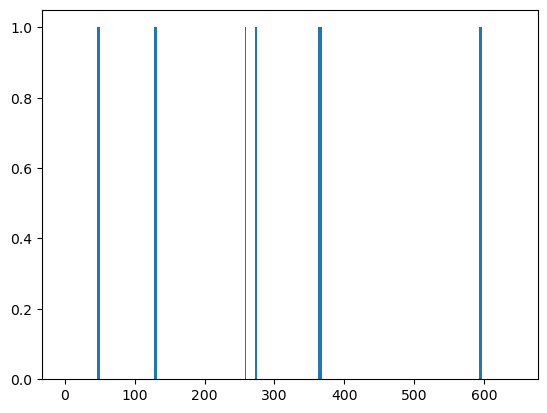

147


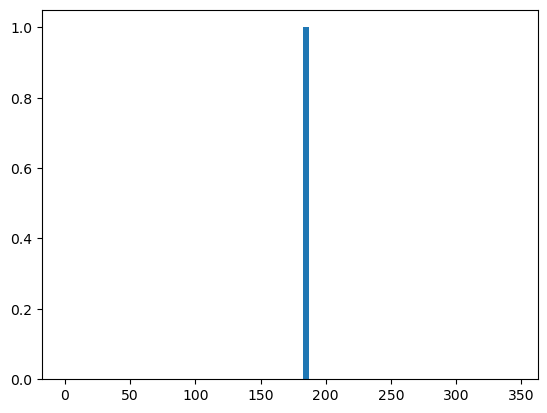

148


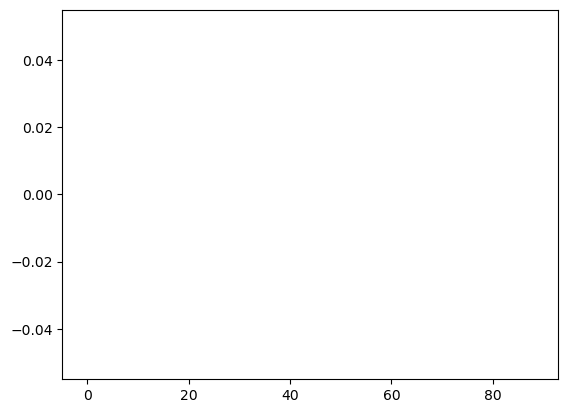

149


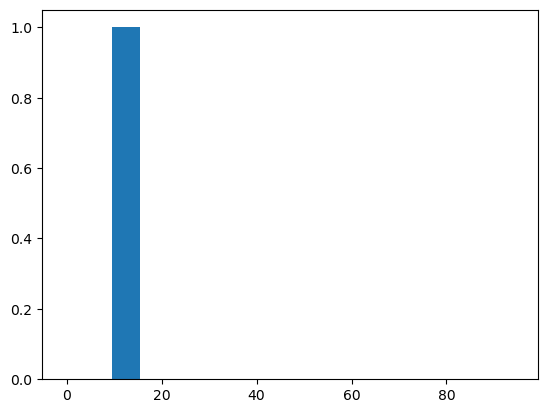

150


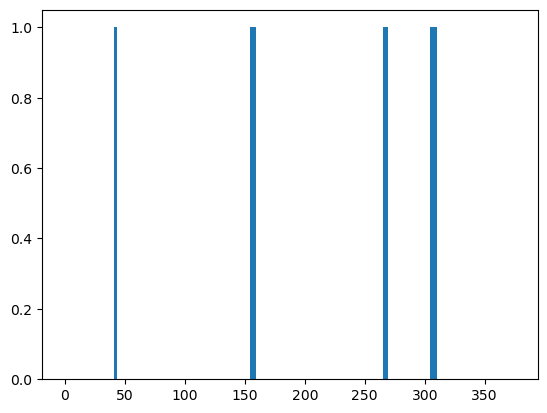

151


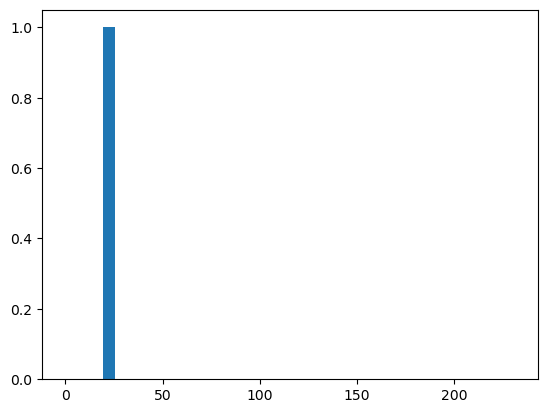

152


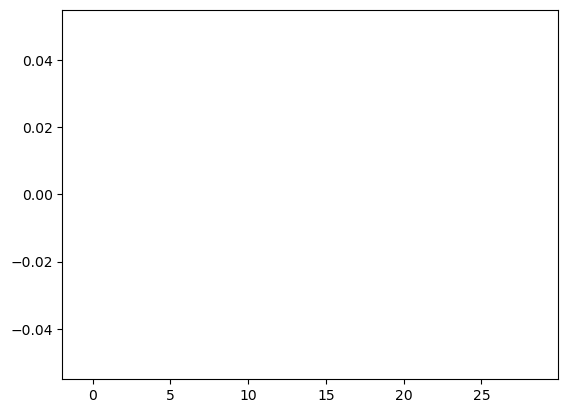

153


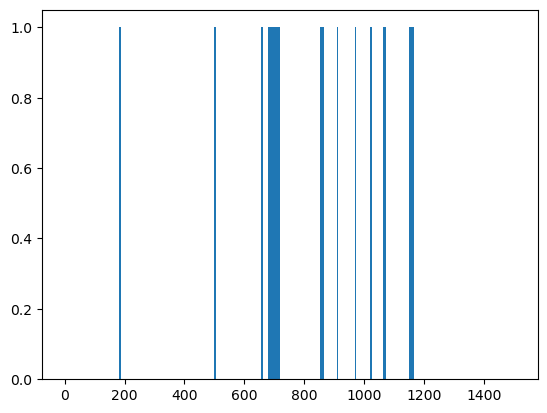

154


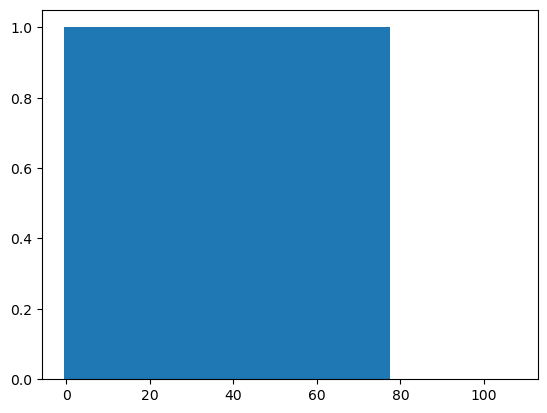

155


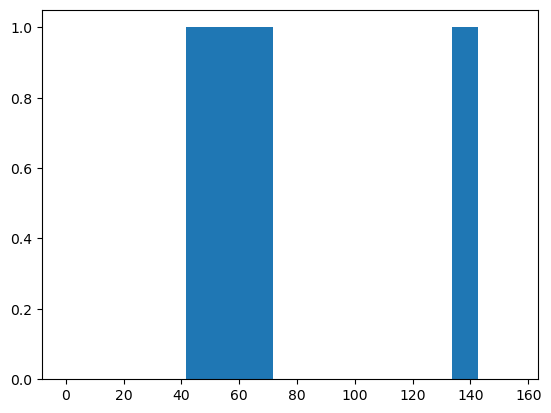

156


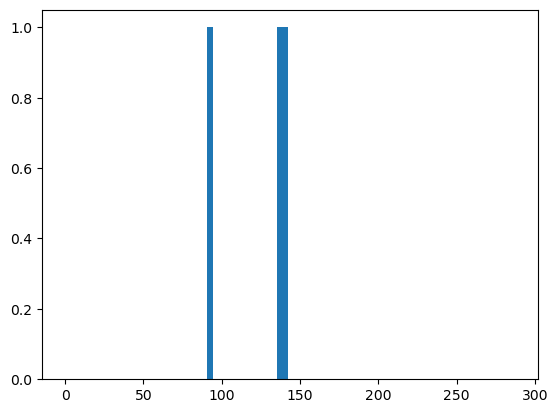

157


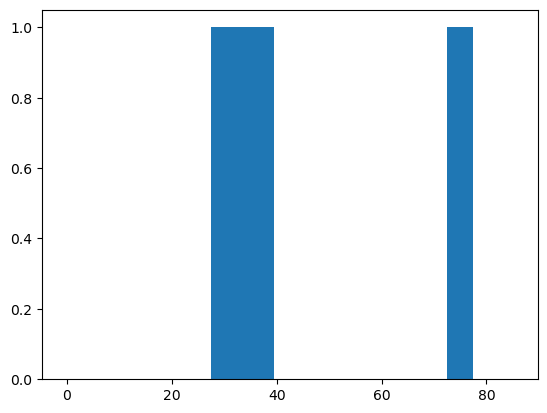

158


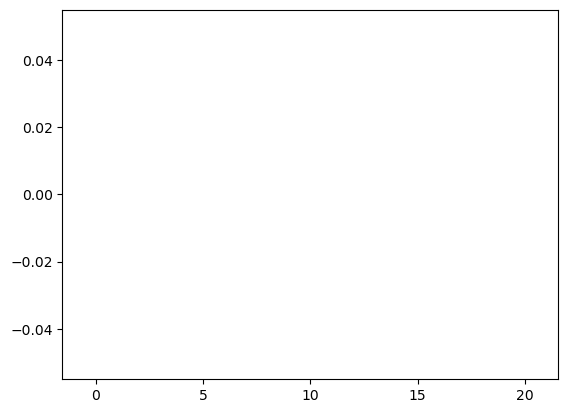

159


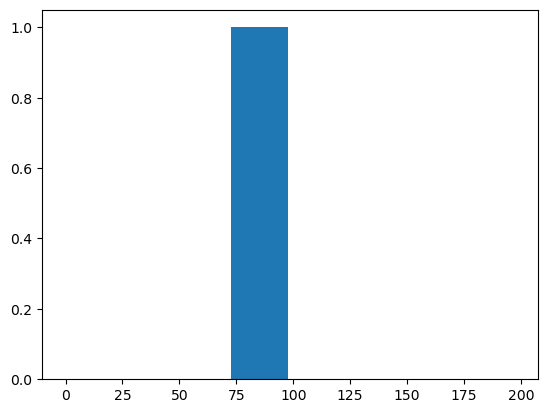

160


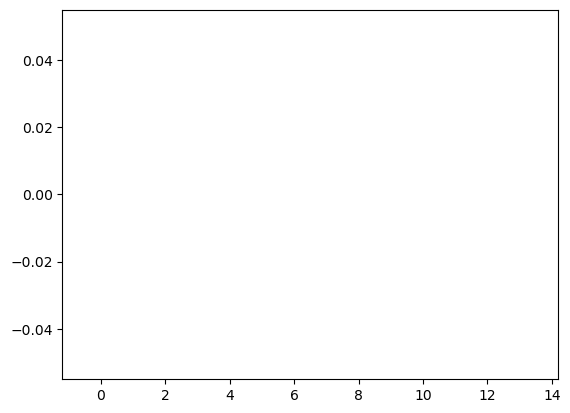

161


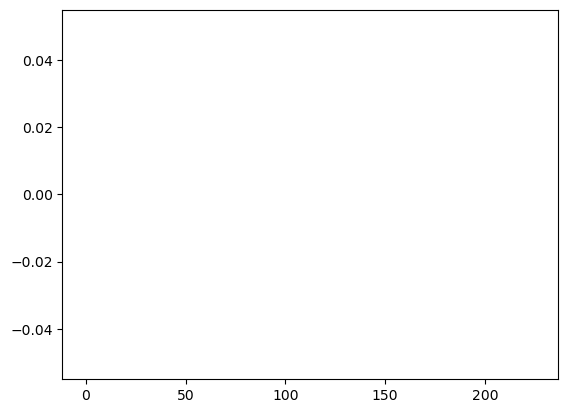

162


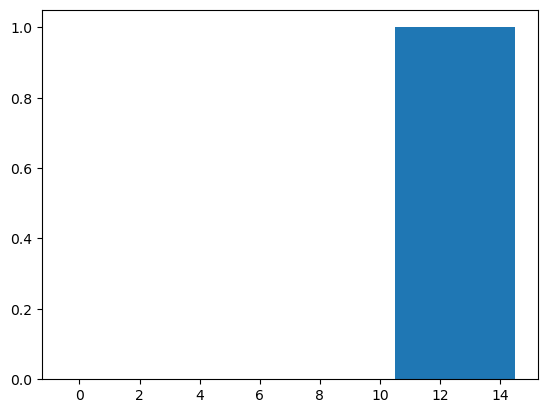

163


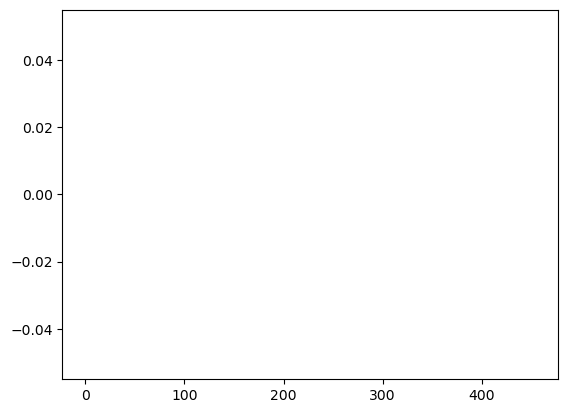

164


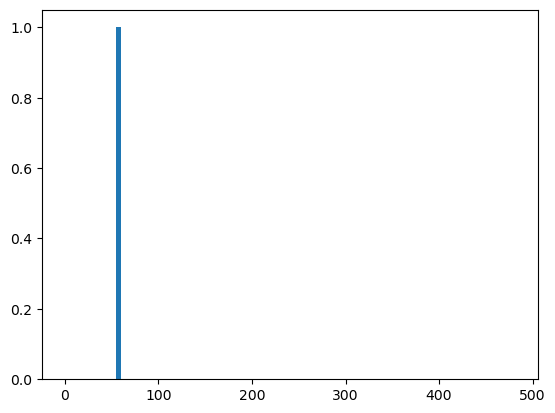

165


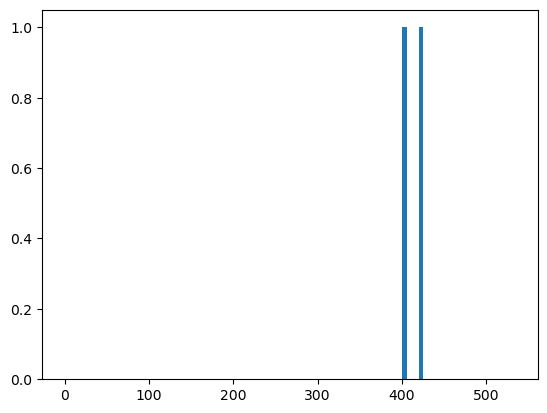

166


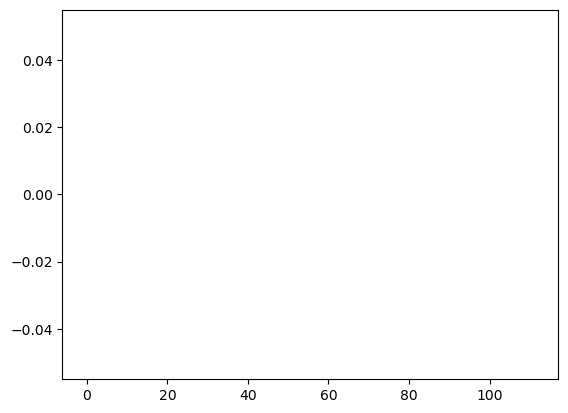

167


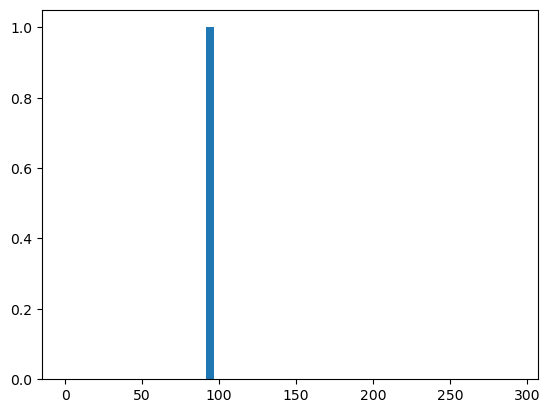

168


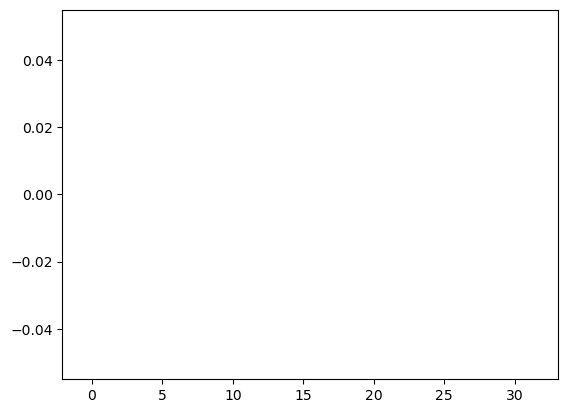

169


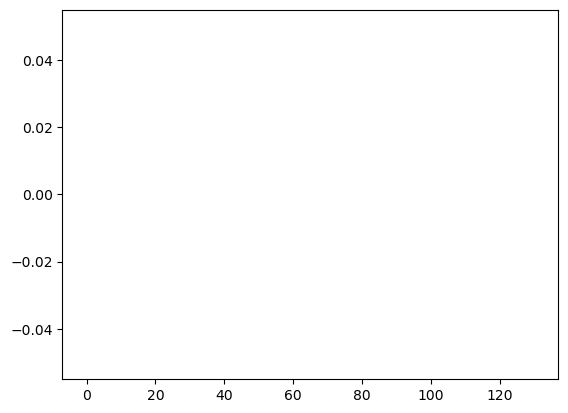

170


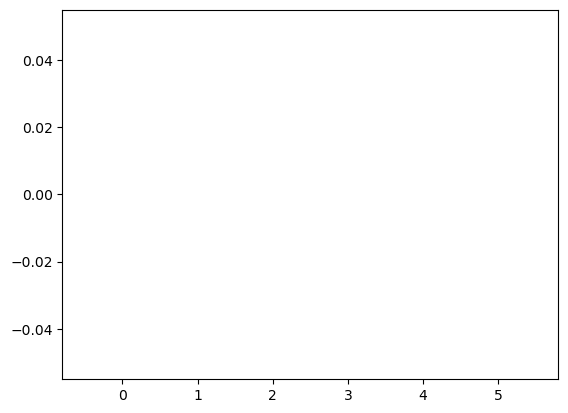

171


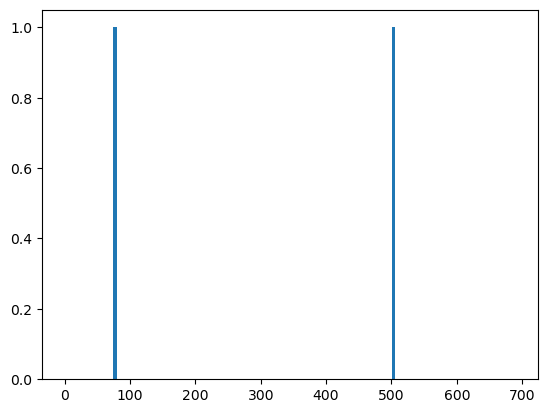

172


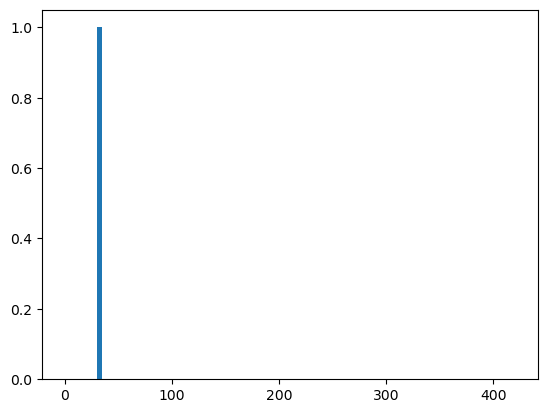

173


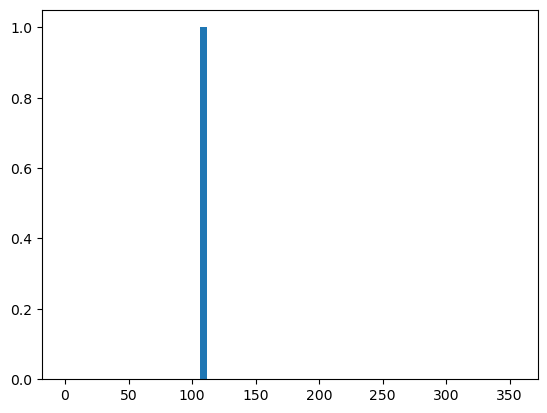

174


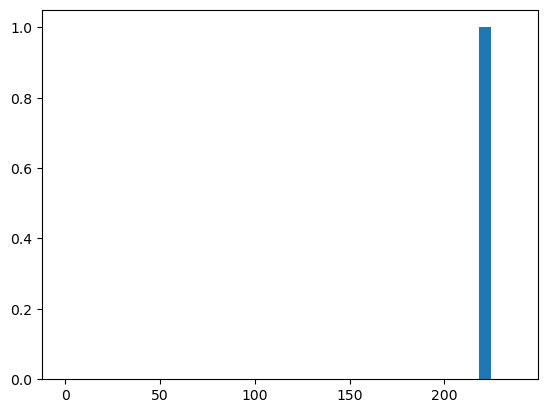

175


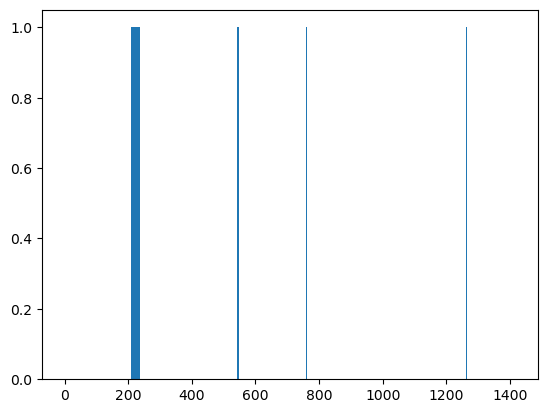

176


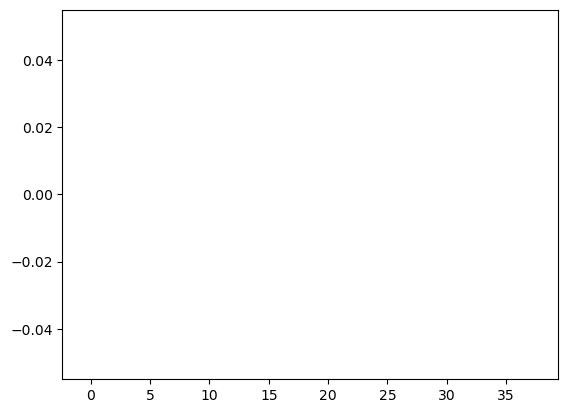

177


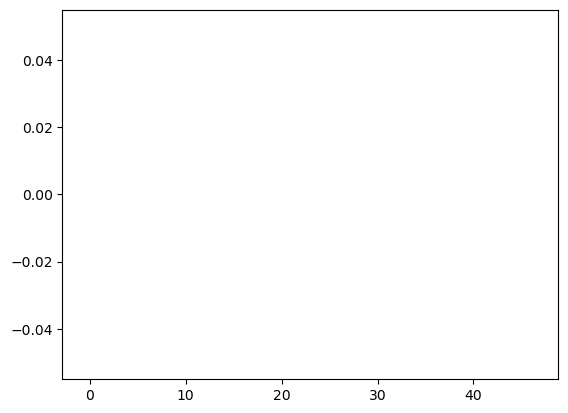

178


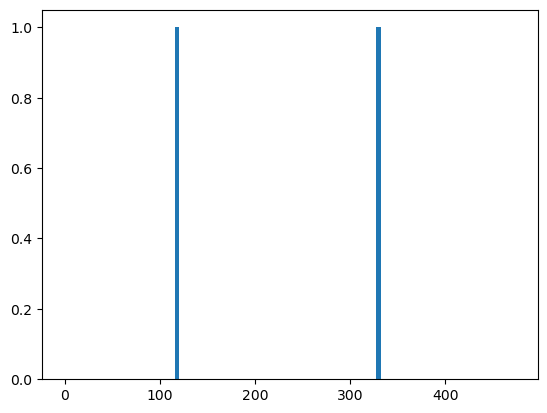

179


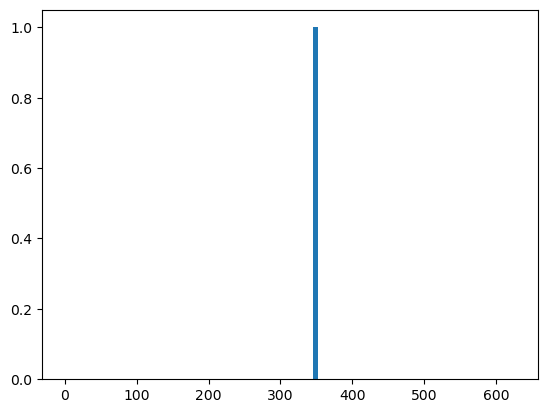

180


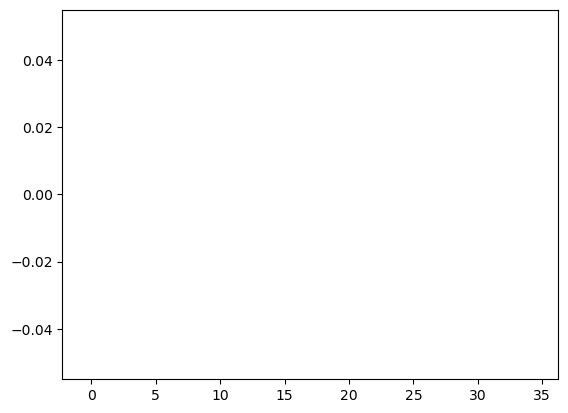

181


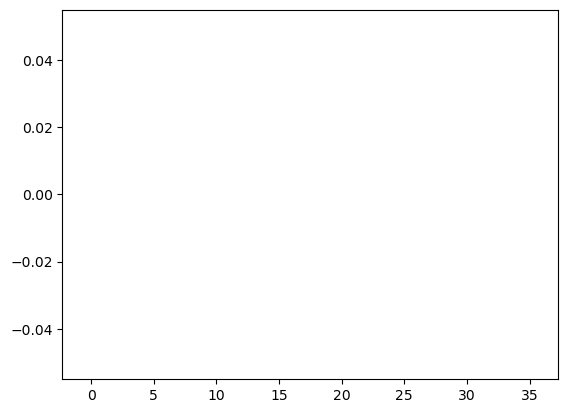

182


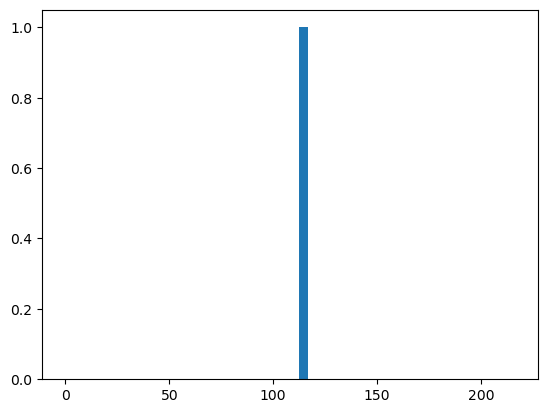

183


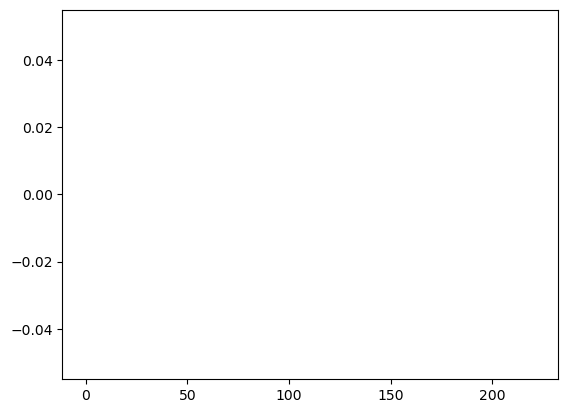

184


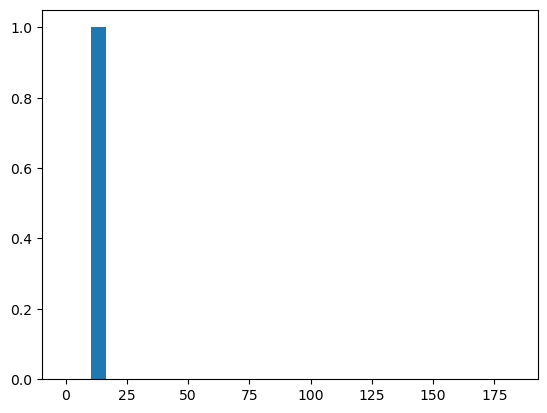

185


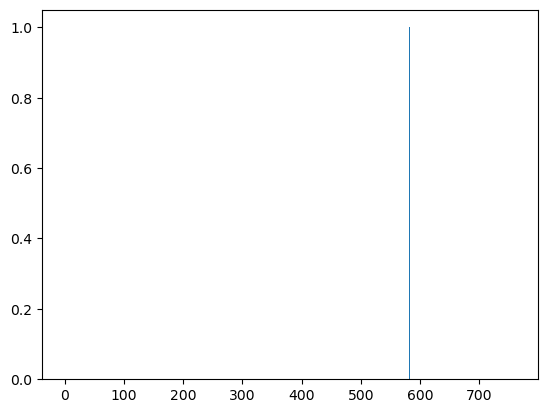

186


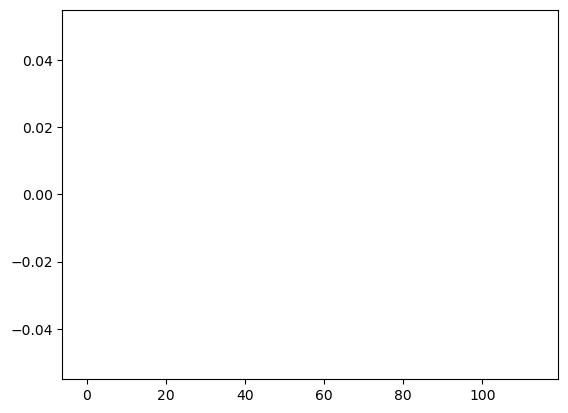

187


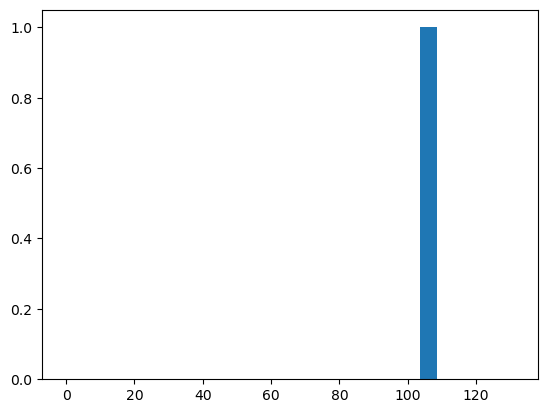

188


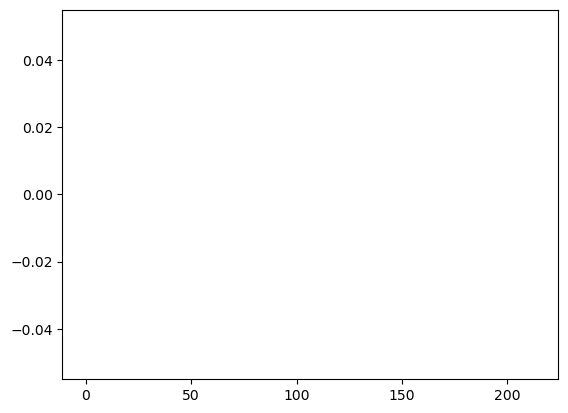

189


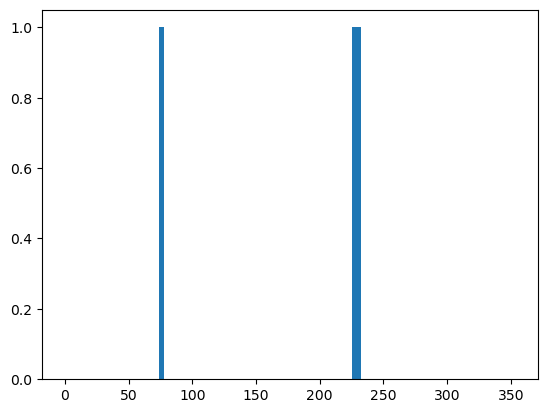

190


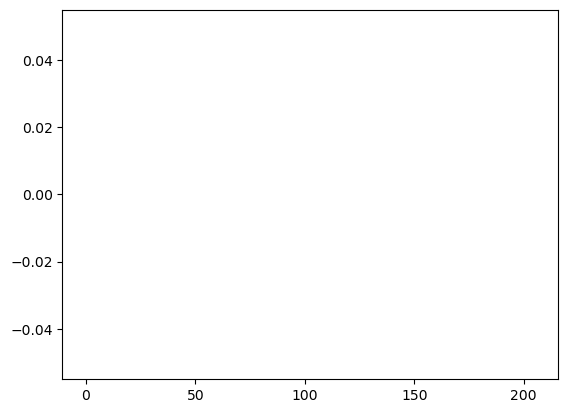

191


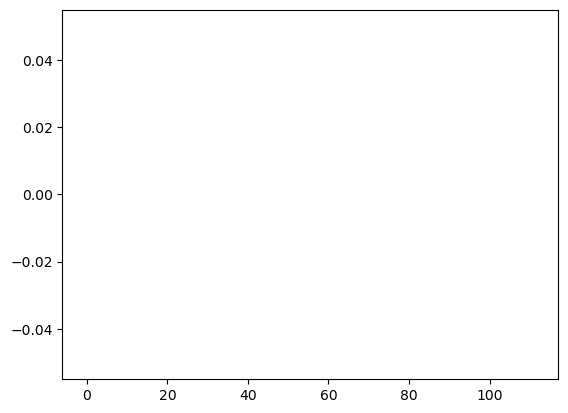

192


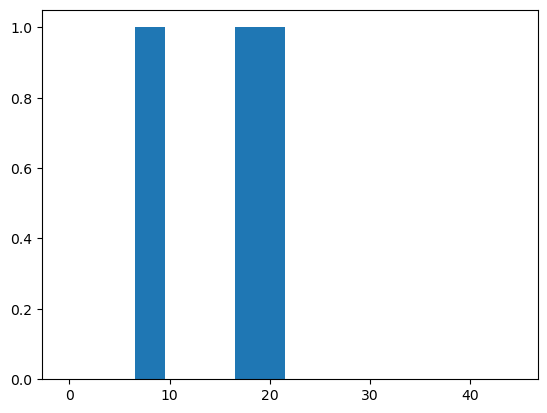

193


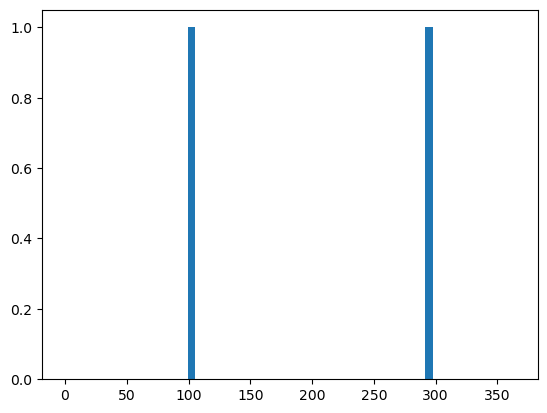

194


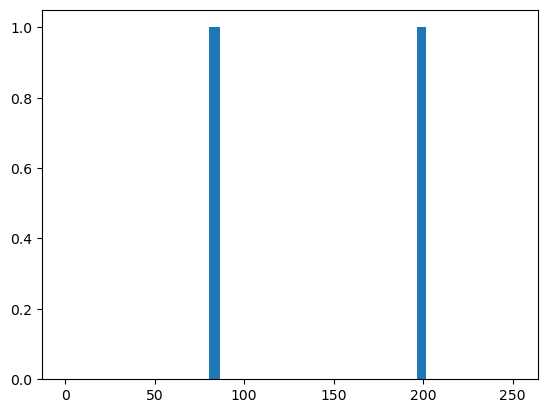

195


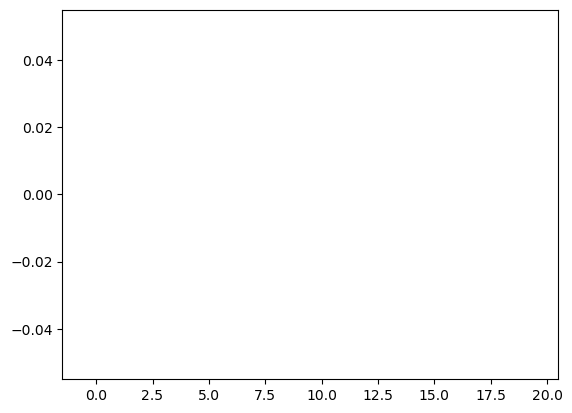

196


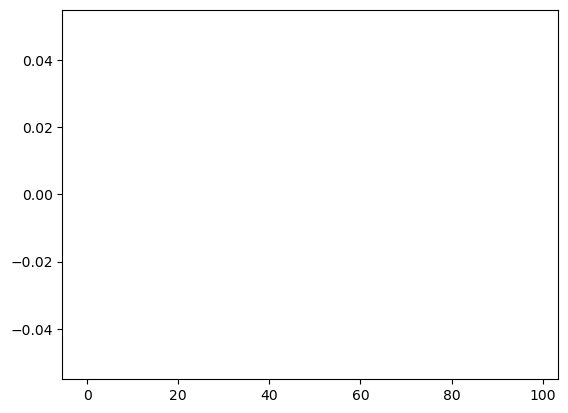

197


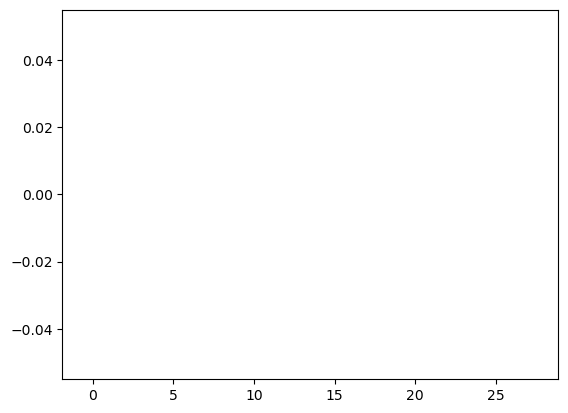

198


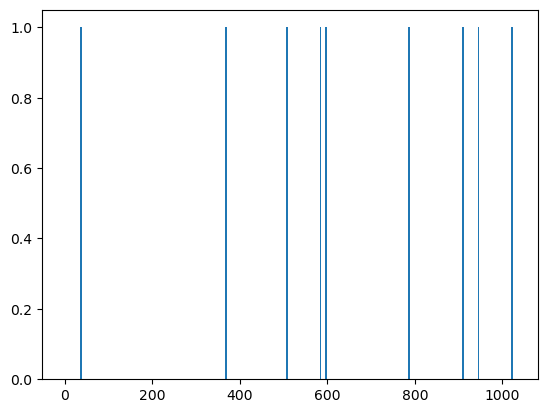

199


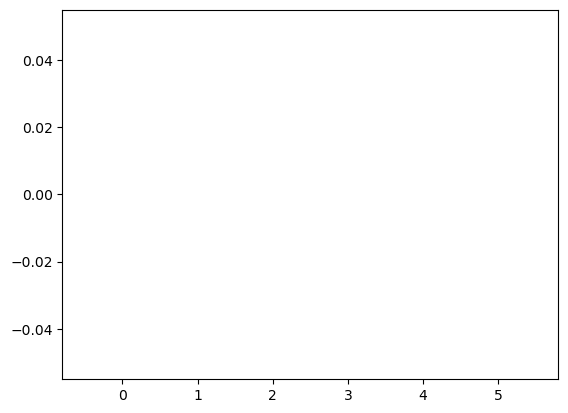

In [156]:
#Simple visualization of specific block:

for i in range(0, 200):
    print(i)
    t = test[test['BlockID'] == i]['S118']
    x = np.arange(len(t))
    plt.bar(x, t, width=1)  # larghezza massima per togliere lo spazio
    
    plt.show()

# ROC score 

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

def ROC_ScoreDF(df):

    #Filters all the blockID such that there is at least 1 anomaly
    AnomalousBlocks_df = (
        df
        .groupBy("BlockID")
        .agg(F.max("HasAnomaly").alias("HasAnomalyFlag"))
        .filter(F.col("HasAnomalyFlag") == 1)
        .select("BlockID"))

    #Filter the initial dataframe with only the anomalous blocks
    AnomDF = df.join(AnomalousBlocks_df, on="BlockID", how="inner")

    #BlockID of anomalous blocks 
    AnomalousBlocks = [row["BlockID"] for row in AnomDF.select("BlockID").distinct().collect()]

    #Computes the number of distinct value for all the metrics in the anomalous dataframe
    Metrics = ChangingMetrics(AnomDF)

    results = []

    #debug 
    AnomalousBlocks = [29]

    #Main loop over all the anomalous block
    for block in AnomalousBlocks:

        sensors = SpecificMetric(Metrics, block, 10)

        #Filter only the current block
        BlockDF = AnomDF.filter(F.col("BlockID") == block)

        HasAnomCol = BlockDF.select("HasAnomaly").collect()
        
        for sensor in sensors:

            print(f'({block}, {sensor})')
            SensorCol = BlockDF.select(sensor).collect()
            
            score = roc_auc_score(HasAnomCol, SensorCol)

            if score is not None:
                results.append((block, sensor, score))

    # Convert to DataFrame
    schema = ["BlockID", "Sensor", "ROC_AUC"]
    result_df = df.sparkSession.createDataFrame(results, schema=schema)

    return result_df
    

    
    

In [31]:
#test = ROC_ScoreDF(df_final)

25/08/09 07:23:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/08/09 07:23:40 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

(29, S10)
(29, S100)
(29, S101)
(29, S102)
(29, S107)
(29, S109)
(29, S122)
(29, S124)
(29, S126)
(29, S138)
(29, S140)
(29, S143)
(29, S147)
(29, S151)
(29, S154)
(29, S157)
(29, S158)
(29, S159)
(29, S164)
(29, S166)
(29, S178)
(29, S180)
(29, S37)
(29, S39)
(29, S40)
(29, S41)
(29, S46)
(29, S47)
(29, S5)
(29, S70)
(29, S71)
(29, S81)
(29, S83)
(29, S9)
(29, S90)
(29, S94)
(29, S97)


In [32]:
PandaDF = df_final.toPandas()

Anom = PandaDF[PandaDF['BlockID'] == 119]
Norm = PandaDF[PandaDF['BlockID'] == 118]

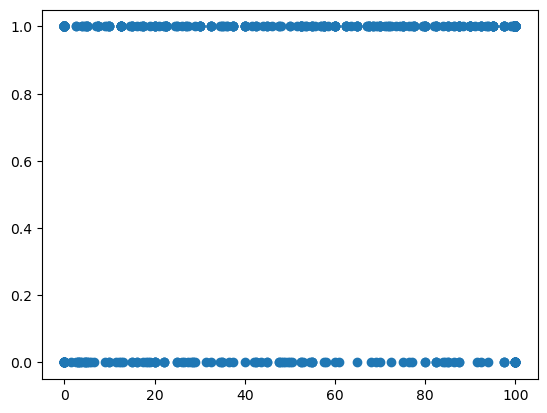

In [33]:
Complete = pd.concat([Norm, Anom])

HasAnom118 = np.zeros(len(Norm))
HasAnom119 = np.ones(len(Anom))
HasAnom = np.concatenate([HasAnom118, HasAnom119])

P10 = Complete['S10']

plt.scatter(P10, HasAnom)


In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

score = roc_auc_score(HasAnom, P10)
score

0.576312910284464

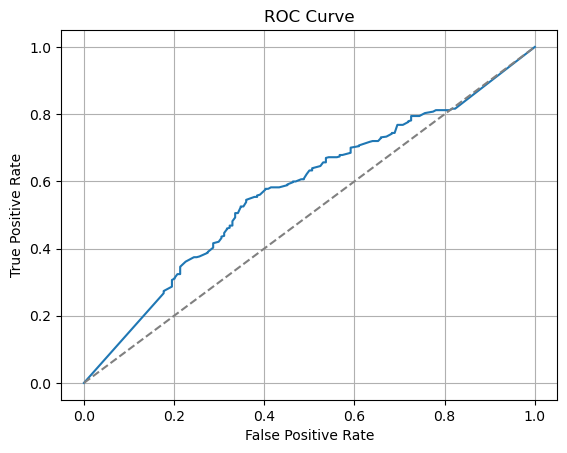

In [35]:
fpr, tpr, thresholds = roc_curve(HasAnom, P10)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # no-skill line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

# Test Mutual Information

In [42]:
from sklearn.feature_selection import mutual_info_classif

ExcludedCol = {"window_id", "when", "window_start", "window_end", "ComError", 
                     "Prev_TimeStamp", "TimeDiff_s", "CheckNewBlock", "BlockID"}

def MutualInformation(df):

    
    #Filters all the blockID such that there is at least 1 anomaly
    AnomalousBlocks_df = (
        df
        .groupBy("BlockID")
        .agg(F.max("HasAnomaly").alias("HasAnomalyFlag"))
        .filter(F.col("HasAnomalyFlag") == 1)
        .select("BlockID"))

    #Filter the initial dataframe with only the anomalous blocks
    AnomDF = df.join(AnomalousBlocks_df, on="BlockID", how="inner")

    #BlockID of anomalous blocks 
    AnomalousBlocks = [row["BlockID"] for row in AnomDF.select("BlockID").distinct().collect()]

    results = []

    AnomalousBlocks = [1, 2, 3, 4, 5]

    #Main loop over all the anomalous block
    for block in AnomalousBlocks:

        #debug
        print(block)

        #Filter only the current block
        BlockDF = AnomDF.filter(F.col("BlockID") == block).select(*sensors, 'HasAnomaly').drop(*ExcludedCol)
        HasAnomCol = np.ravel(BlockDF.select("HasAnomaly").collect())
        BlockDF = BlockDF.collect() 

        try:
            MI_score = mutual_info_classif(BlockDF, HasAnomCol)
        except:
            print('NaN values found!')

        #Maybe here we can filter by Mutual information score: The highest one are saved, the one with 0 no

        results.append((block*[1]*len(sensors), sensors, MI_score[:-1]))

                

    # Convert to DataFrame
    result_df = pd.DataFrame(results, columns=["BlockID", "Sensors", "MI_score"])

    return result_df

        

In [43]:
%%time
test = MutualInformation(df_final)

1


2


3


4


5


[Stage 2501:===================================================>(199 + 1) / 200]

CPU times: user 1.21 s, sys: 77.6 ms, total: 1.29 s
Wall time: 17.7 s


In [171]:
spark.stop()